<h1 class="text-success text-center">
Projet 7: Implémentez un modèle de scoring
<br>
<p>
    <small>Chafaa BENHACINE |  Parcours : Data Scientist<small>
<br>
   Dernière mise à jour : 12/2021
 </p>
</h1>

  # <span style='background:#7FFFD4'>Notebook_03 - FEATURES SELECTION</span>

Ce notebook traite de la **`feature sélection`** des jeux de données des dataframes **`train_set`** et **`test_set`** composés des pré-processing (nettoyage, feature engineering)/aggrégations de tous les fichiers mis à notre disposition:

- **bureau.csv**,
- **bureau_balance.csv**,
- **credit_card_balance.csv**,
- **installments_payments.csv**,
- **POS_CASH_balance.csv**,
- **previous_application.csv**

En particulier :

- **`Feature selection`** : outre la génération de caractéristiques importantes/utiles, il est également essentiel de supprimer les caractéristiques redondantes et bruyantes. Si nous introduisons des déchets/bruits dans notre modèle d'apprentissage automatique, il retournera des déchets/bruits. Nous devons donc trouver de bonnes techniques de sélection des caractéristiques les plus importantes et discriminantes pour notre problématique.

***
Sources
***
Kernel Kaggle sur Home Credit :
- Feature sélection avec Lightgbm : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
- Feature sélection avec BORUTA : [Source](https://www.kaggle.com/rsmits/feature-selection-with-boruta).
- Feature sélection avec BOOSTAROOTA : [Source](https://github.com/Murfin/nn_project/blob/master/NN%20project%20notebook%20ver.%202.ipynb)

## <span>Sommaire du notebook</span> 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span>1. Introduction</span>

In [2]:
!pip install catboost

In [3]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import jyquickhelper
import numpy as np
import pandas as pd
import os

import P7_01_08_outils_data as outils_data
import P7_01_07_eda_kernel_fonctions as eda_kernel_fonctions
import P7_01_09_outils_model as outils_model
import P7_01_10_outils_preprocessing as outils_preprocessing
import pickle

import matplotlib.pyplot as plt

# Modelisation
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Features selection
from boruta import BorutaPy
from BorutaShap import BorutaShap
from collections import Counter

# Warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
%pycodestyle_on
# %pycodestyle_off

# Versions
print('\n___Version des librairies utilisées___ :\n')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Lightgbm              : ' + lgb.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils pré-processing : ' + outils_preprocessing.__version__)
print('Outils model          : ' + outils_model.__version__)
print('EDA Kernel fonctions  : ' + eda_kernel_fonctions.__version__)
now = datetime.now().isoformat()
print('\nLancé le           : ' + now)


___Version des librairies utilisées___ :

jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.4
Lightgbm              : 3.3.0
Outils dataframe      : 0.0.4
Outils pré-processing : 0.0.0
Outils model          : 0.0.1
EDA Kernel fonctions  : 0.0.0

Lancé le           : 2021-12-09T17:19:25.316196


In [4]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span>2. Chargement des jeux de données</span>

**Chargement des dataframes nettoyés**

In [5]:
fic_sav_train_set = \
    'OUTPUT_DATA/train_set_preproc.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 590)

In [6]:
fic_sav_appli_train_imp1 = \
    'OUTPUT_DATA/train_imp1_set_preproc.pickle'
# Chargement de train_imp1_set
with open(fic_sav_appli_train_imp1, 'rb') as df_appli_train_imp1_set:
    train_imp1_set = pickle.load(df_appli_train_imp1_set)
train_imp1_set.shape

(307507, 597)

In [7]:
fic_sav_appli_train_imp2 = \
    'OUTPUT_DATA/train_imp2_set_preproc.pickle'
# Chargement de train_imp2_set
with open(fic_sav_appli_train_imp2, 'rb') as df_appli_train_imp2_set:
    train_imp2_set = pickle.load(df_appli_train_imp2_set)
train_imp2_set.shape

(307507, 592)

In [8]:
fic_sav_test_set = \
    'OUTPUT_DATA/test_set_preproc.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 648)

In [9]:
fic_sav_appli_test_imp1 = \
    'OUTPUT_DATA/test_imp1_set_preproc.pickle'
# Chargement de test_imp1_set
with open(fic_sav_appli_test_imp1, 'rb') as df_appli_test_imp1_set:
    test_imp1_set = pickle.load(df_appli_test_imp1_set)
test_imp1_set.shape

(48744, 655)

In [10]:
fic_sav_appli_test_imp2 = \
    'OUTPUT_DATA/test_imp2_set_preproc.pickle'
# Chargement de test_imp2_set
with open(fic_sav_appli_test_imp2, 'rb') as df_appli_test_imp2_set:
    test_imp2_set = pickle.load(df_appli_test_imp2_set)
test_imp2_set.shape

(48744, 631)

## <span>3. Features selection</span> 

### <span>3.1. Features selection : avec LIGHTGBM</span>

- Extrait du Kernel Kaggle : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
- Le but est de conserver uniquement les variables les plus pertinentes en utilisant les features importance déterminée par un modèle, Lightgbm dans notre cas.

<span>**Train_set / test_set**</span>

- La variable magique TARGET_NEIGHBORS_500_MEAN peut être controverser par un client sur le recueil des données des autres clients et difficile à expliquer facilement à un client donc nous allons tester avec ou sans cette variable.

<span>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

**Préparation des dataframes de travail**

In [11]:
# Résumé des variables qualitatives
desc_train_set = outils_data.description_variables(train_set)
desc_train_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,...,PREV_APP_PRODUCT_COMBINATION_POS_HOUSEHOLD_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_OTHERS_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_OTHERS_WITHOUT_INTEREST_MEAN,PREV_APP_AMT_ANNUITY_MEAN,PREV_APP_AMT_ANNUITY_SUM,PREV_APP_AMT_ANNUITY_MIN,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_MIN,PREV_APP_AMT_DOWN_PAYMENT_MEAN,PREV_APP_AMT_GOODS_PRICE_MIN,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,PREV_APP_FLAG_LAST_APPL_PER_CONTRACT_MEAN,PREV_APP_NFLAG_LAST_APPL_IN_DAY_MEAN,PREV_APP_RATE_DOWN_PAYMENT_MEAN,PREV_APP_NAME_CONTRACT_STATUS_MEAN,PREV_APP_NAME_CONTRACT_STATUS_LAST,PREV_APP_DAYS_DECISION_MEAN,PREV_APP_DAYS_DECISION_MAX,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_SELLERPLACE_AREA_MIN,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_NAME_YIELD_GROUP_MEAN,PREV_APP_NAME_YIELD_GROUP_LAST,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM,PREV_APP_AMT_DECLINED_MEAN,PREV_APP_AMT_DECLINED_SUM,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM,PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_LOAN_RATE_MAX,PREV_APP_LOAN_RATE_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_INTEREST_SHARE_MEAN,PREV_APP_INTEREST_

In [12]:
# Dataframes de travail
train_sans_fs_lgbm = train_set.copy()
train_sans_fs_lgbm = train_sans_fs_lgbm.drop(['TARGET_NEIGHBORS_500_MEAN'],
                                             axis=1)
print(f'train_sans_fs_lgbm : {train_sans_fs_lgbm.shape}')
test_sans_fs_lgbm = test_set.copy()
test_sans_fs_lgbm = test_sans_fs_lgbm.drop(['TARGET_NEIGHBORS_500_MEAN'],
                                           axis=1)
print(f'test_sans_fs_lgbm : {test_sans_fs_lgbm.shape}')

train_sans_fs_lgbm : (307507, 589)
test_sans_fs_lgbm : (48744, 647)


In [13]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_sans_fs_lgbm_labels = train_sans_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_sans_fs_lgbm_ids = train_sans_fs_lgbm['SK_ID_CURR']
test_sans_fs_lgbm_ids = test_sans_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_sans_fs_lgbm, test_sans_fs_lgbm = \
    train_sans_fs_lgbm.align(test_sans_fs_lgbm, join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_sans_fs_lgbm = train_sans_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_sans_fs_lgbm = test_sans_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_fs_lgbm : {train_sans_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_sans_fs_lgbm.shape}')

train_fs_lgbm : (307507, 587)
test_fs_lgbm : (48744, 587)


**Modélisation**

***Premier passage***

In [14]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_sans = np.zeros(train_sans_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [15]:
import re
#feature_importances_sans = feature_importances_sans.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_sans_features, valid_sans_features, train_sans_y, valid_sans_y = \
        train_test_split(train_sans_fs_lgbm, train_sans_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_sans_features, train_sans_y,
              early_stopping_rounds=100,
              eval_set=[(valid_sans_features, valid_sans_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances_sans += model.feature_importances_

[200]	valid_0's auc: 0.786759	valid_0's binary_logloss: 0.510735
[200]	valid_0's auc: 0.784008	valid_0's binary_logloss: 0.508134


2:1: E265 block comment should start with '# '
2:80: E501 line too long (111 > 79 characters)


In [16]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances_sans = feature_importances_sans / 2
df_fs_sans_lightgbm = \
    pd.DataFrame({'feature': list(train_sans_fs_lgbm.columns),
                  'importance': feature_importances_sans}) \
    .sort_values('importance', ascending=False)

df_fs_sans_lightgbm.head()

,feature,importance
69,CREDIT_ANNUITY_RATIO,159.0
78,EXT_SOURCE_SUM,125.5
9,DAYS_BIRTH,116.5
253,INST_PAY_DAYS_PAYMENT_RATIO_MAX,100.5
26,EXT_SOURCE_1,84.5


In [17]:
# Exploration des variables avec zéro importance
zero_features_sans = \
    list(df_fs_sans_lightgbm[df_fs_sans_lightgbm['importance'] == 0.0][
        'feature'])
print(f'{len(zero_features_sans)} variables avec 0.0 importance :\n')
zero_features_sans

164 variables avec 0.0 importance :



['CCB_NAME_CONTRACT_STATUS_DEMAND_SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_3_MEAN',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_2',
 'FLAG_MOBIL',
 'FLAG_DOCUMENT_17',
 'BUREAU_CREDIT_TYPE_MOBILE_OPERATOR_LOAN_SUM',
 'NAME_INCOME_TYPE_STUDENT',
 'NAME_TYPE_SUITE_OTHER_A',
 'NAME_INCOME_TYPE_UNEMPLOYED',
 'NAME_INCOME_TYPE_BUSINESSMAN',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_12',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM',
 'FLAG_DOCUMENT_10',
 'BUREAU_CREDIT_TYPE_REAL_ESTATE_LOAN_SUM',
 'FLAG_DOCUMENT_9',
 'BUREAU_CREDIT_TYPE_REAL_ESTATE_LOAN_MEAN',
 'BUREAU_CREDIT_TYPE_UNKNOWN_TYPE_OF_LOAN_SUM',
 'BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM',
 'CCB_AMT_PAYMENT_TOTAL_CURRENT_MIN',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_14',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT_SUM',
 'BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SUM',
 'PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_2_SUM',
 'NAME_TYPE_SUITE_GROUP_OF_

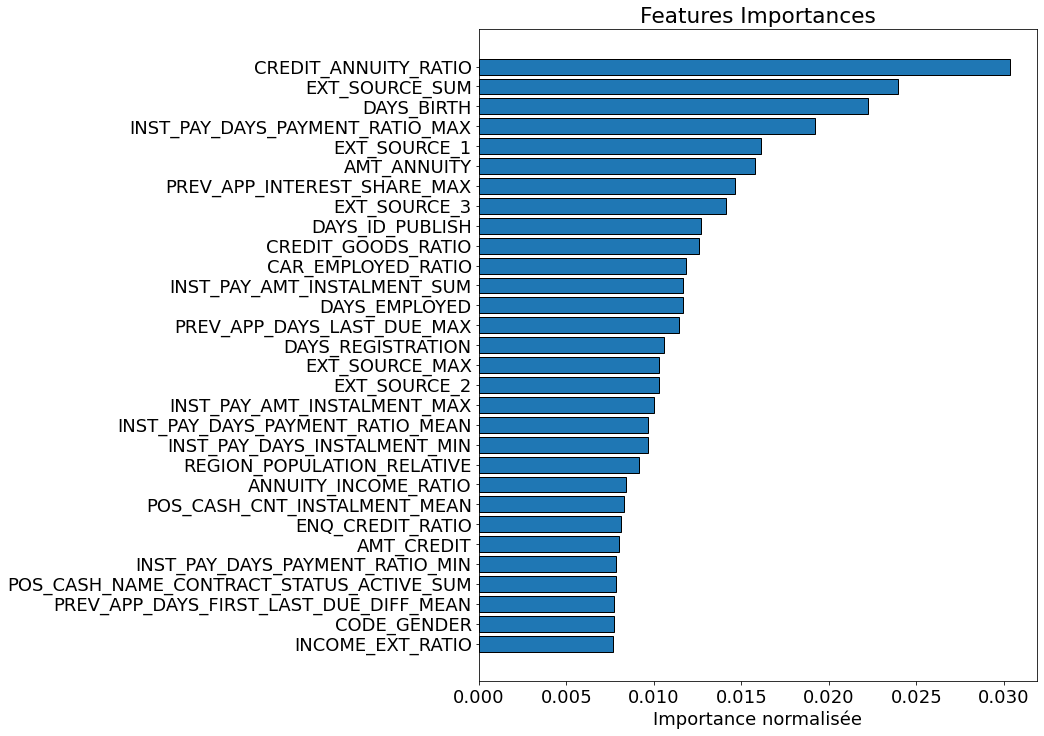

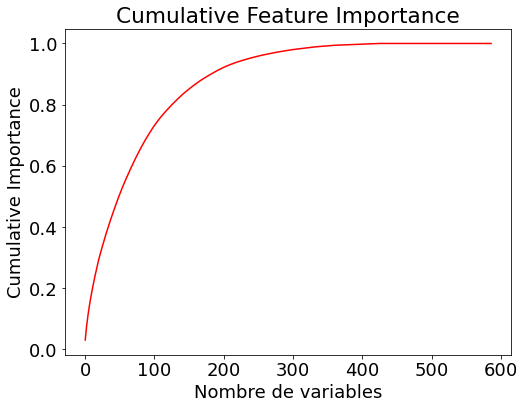

183 variables nécessaires pour 0.90 de cumulative importance


In [18]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_sans_lightgbm_norm = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_sans_lightgbm)

In [19]:
# Suppression des variables avec zéro importance
train_sans_fs_lgbm = train_sans_fs_lgbm.drop(columns=zero_features_sans)
test_sans_fs_lgbm = test_sans_fs_lgbm.drop(columns=zero_features_sans)

print(f'train_sans_fs_lgbm : {train_sans_fs_lgbm.shape}')
print(f'test_sans_fs_lgbm : {test_sans_fs_lgbm.shape}')

train_sans_fs_lgbm : (307507, 423)
test_sans_fs_lgbm : (48744, 423)


***Second passage***

In [20]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2_sans, df_fs_sans_lightgbm_2 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_sans_fs_lgbm,
                                       train_sans_fs_lgbm_labels)

[200]	valid_0's auc: 0.787117	valid_0's binary_logloss: 0.510467
[200]	valid_0's auc: 0.784008	valid_0's binary_logloss: 0.508134

There are 0 features with 0.0 importance


**Sauvegarde**

In [21]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_sans_lightgbm = \
    'OUTPUT_DATA/fs_sans_lightgbm.pickle'
with open(fic_sav_fs_sans_lightgbm, 'wb') as f:
    pickle.dump(df_fs_sans_lightgbm_2, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [22]:
# Chargement des features importance de ligthgbm
fic_sav_fs_sans_lightgbm = \
    'OUTPUT_DATA/fs_sans_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_sans_lightgbm, 'rb') as df_fs_sans_lightgbm:
    df_fs_sans_lightgbm = pickle.load(df_fs_sans_lightgbm)
df_fs_sans_lightgbm.shape

(423, 2)

In [23]:
# Sauvegarde du nombre de features importance
df_fs_sans_train_set = pd.DataFrame({})
df_fs_sans_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_sans_lightgbm,
                                                    df_fs_sans_train_set,
                                                    'train_sans_set',
                                                    'lightgbm')

train_sans_set - lightgbm : 423 variables importantes conservées


<span>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

**Préparation des dataframes de travail**

In [24]:
# Résumé des variables qualitatives
desc_train_set = outils_data.description_variables(train_set)
desc_train_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_UNEMPLOYED,NAME_INCOME_TYPE_WORKING,...,PREV_APP_PRODUCT_COMBINATION_POS_HOUSEHOLD_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_OTHERS_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_OTHERS_WITHOUT_INTEREST_MEAN,PREV_APP_AMT_ANNUITY_MEAN,PREV_APP_AMT_ANNUITY_SUM,PREV_APP_AMT_ANNUITY_MIN,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_MIN,PREV_APP_AMT_DOWN_PAYMENT_MEAN,PREV_APP_AMT_GOODS_PRICE_MIN,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,PREV_APP_FLAG_LAST_APPL_PER_CONTRACT_MEAN,PREV_APP_NFLAG_LAST_APPL_IN_DAY_MEAN,PREV_APP_RATE_DOWN_PAYMENT_MEAN,PREV_APP_NAME_CONTRACT_STATUS_MEAN,PREV_APP_NAME_CONTRACT_STATUS_LAST,PREV_APP_DAYS_DECISION_MEAN,PREV_APP_DAYS_DECISION_MAX,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_SELLERPLACE_AREA_MIN,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_NAME_YIELD_GROUP_MEAN,PREV_APP_NAME_YIELD_GROUP_LAST,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM,PREV_APP_AMT_DECLINED_MEAN,PREV_APP_AMT_DECLINED_SUM,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM,PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_LOAN_RATE_MAX,PREV_APP_LOAN_RATE_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_INTEREST_SHARE_MEAN,PREV_APP_INTEREST_

In [25]:
# Dataframes de travail
train_fs_lgbm = train_set.copy()
print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
test_fs_lgbm = test_set.copy()
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 590)
test_fs_lgbm : (48744, 648)


In [26]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_fs_lgbm_labels = train_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_fs_lgbm_ids = train_fs_lgbm['SK_ID_CURR']
test_fs_lgbm_ids = test_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_fs_lgbm, test_fs_lgbm = train_fs_lgbm.align(test_fs_lgbm,
                                                  join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_lgbm = train_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_fs_lgbm = test_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 588)
test_fs_lgbm : (48744, 588)


**Modélisation**

***Premier passage***

In [27]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances = np.zeros(train_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [28]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_features, valid_features, train_y, valid_y = \
        train_test_split(train_fs_lgbm, train_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_features, train_y,
              early_stopping_rounds=100,
              eval_set=[(valid_features, valid_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances += model.feature_importances_

[200]	valid_0's auc: 0.793267	valid_0's binary_logloss: 0.505235
[200]	valid_0's auc: 0.789002	valid_0's binary_logloss: 0.502975


In [29]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances = feature_importances / 2
df_fs_lightgbm = \
    pd.DataFrame({'feature': list(train_fs_lgbm.columns),
                  'importance': feature_importances}) \
    .sort_values('importance', ascending=False)

df_fs_lightgbm.head()

,feature,importance
85,TARGET_NEIGHBORS_500_MEAN,179.5
9,DAYS_BIRTH,97.5
254,INST_PAY_DAYS_PAYMENT_RATIO_MAX,95.0
78,EXT_SOURCE_SUM,86.5
26,EXT_SOURCE_1,76.0


In [30]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features = \
    list(df_fs_lightgbm[df_fs_lightgbm['importance'] == 0.0]['feature'])
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
zero_features

189 variables avec 0.0 importance :



['PREV_APP_NAME_SELLER_INDUSTRY_MLM_PARTNERS_SUM',
 'PREV_APP_NAME_SELLER_INDUSTRY_MLM_PARTNERS_MEAN',
 'BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM',
 'BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM',
 'PREV_APP_NAME_SELLER_INDUSTRY_TOURISM_SUM',
 'FLAG_CONT_MOBILE',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT_MEAN',
 'PREV_APP_NAME_SELLER_INDUSTRY_JEWELRY_SUM',
 'BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SUM',
 'PREV_APP_NAME_SELLER_INDUSTRY_INDUSTRY_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT_SUM',
 'PREV_APP_PRODUCT_COMBINATION_CARD_X_SELL_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_PURCHASE_OF_SHARES_MARGIN_LENDING__SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_THE_PURCHASE_OF_EQUIPMENT_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_THE_PURCHASE_OF_EQUIPMENT_MEAN',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT_SUM',
 'FLAG_MOBIL',
 'BUREAU_CREDIT_TYPE_MOBILE_OPERATOR_LOAN_SUM',
 'BUREAU_CREDIT_TYPE_REAL_ESTATE_LOAN_SUM',
 'BUREAU_CREDIT_TY

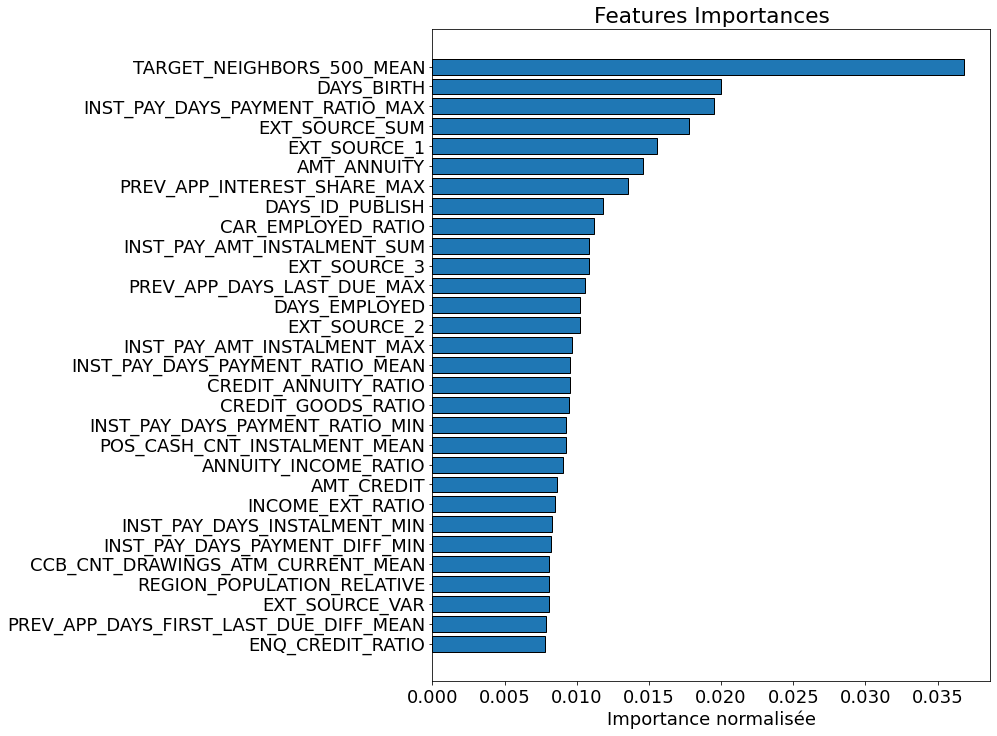

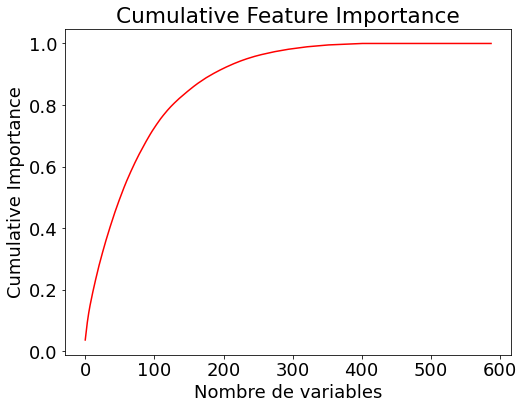

185 variables nécessaires pour 0.90 de cumulative importance


In [31]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm)

In [32]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 399)
test_fs_lgbm : (48744, 399)


***Second passage***

In [33]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2, df_fs_lightgbm_2 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

[200]	valid_0's auc: 0.793611	valid_0's binary_logloss: 0.505347
[200]	valid_0's auc: 0.788664	valid_0's binary_logloss: 0.502484

There are 0 features with 0.0 importance


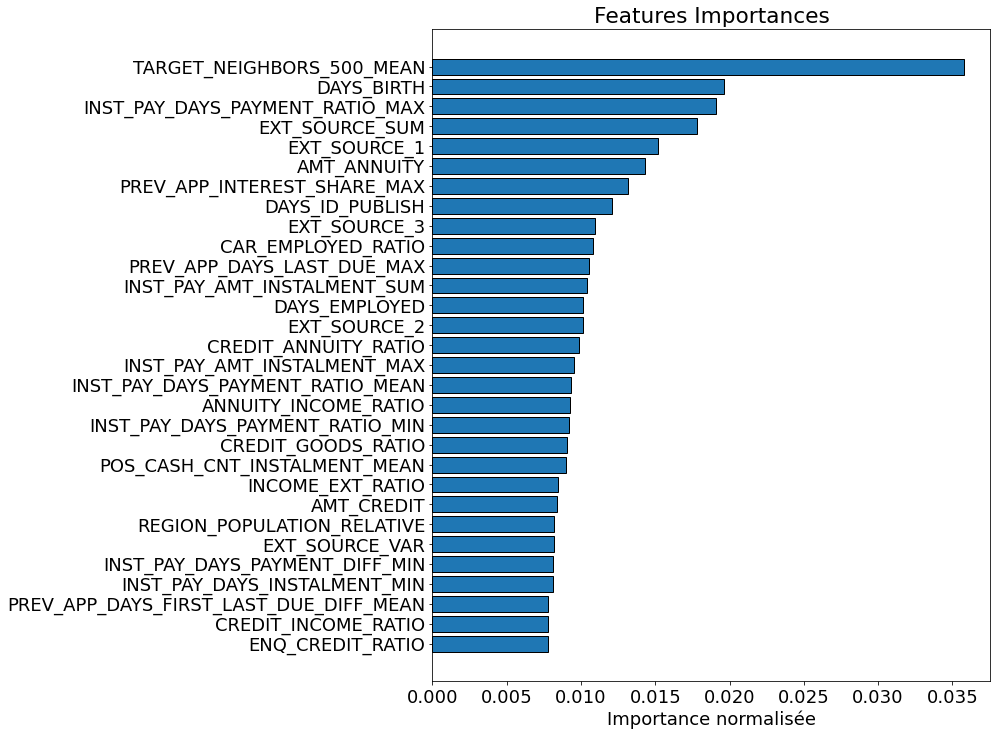

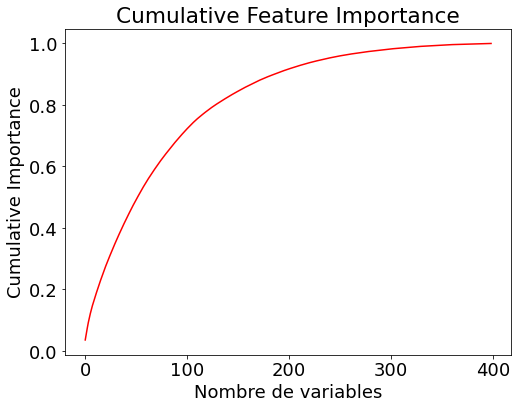

187 variables nécessaires pour 0.90 de cumulative importance


In [34]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_2 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm_2)

In [35]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_2)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_2)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 399)
test_fs_lgbm : (48744, 399)


***Troisième passage***

In [36]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_3, df_fs_lightgbm_3 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

[200]	valid_0's auc: 0.793611	valid_0's binary_logloss: 0.505347
[200]	valid_0's auc: 0.788664	valid_0's binary_logloss: 0.502484

There are 0 features with 0.0 importance


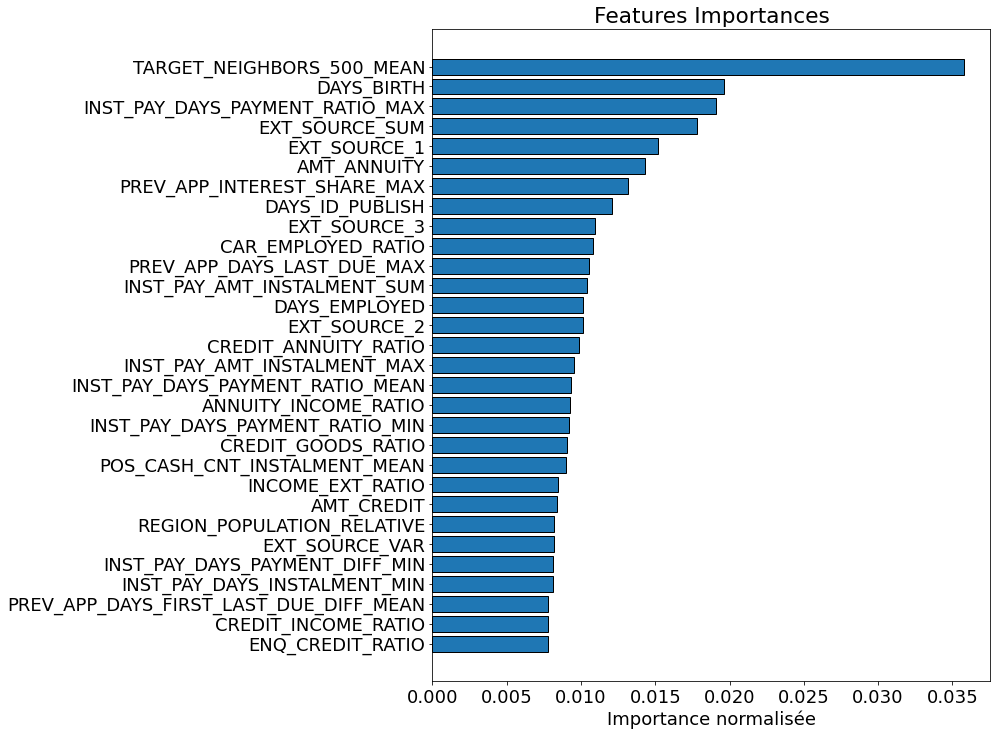

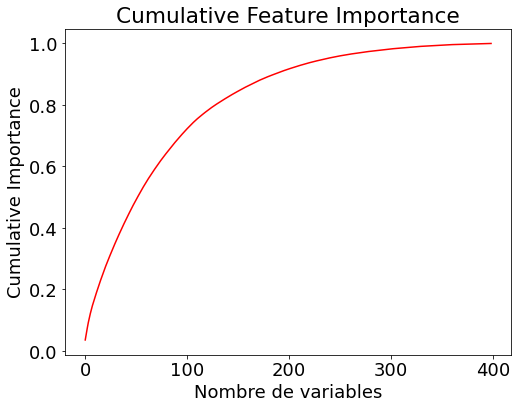

187 variables nécessaires pour 0.90 de cumulative importance


In [37]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_3 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm_3)

In [38]:
# Suppression des variables avec zéro importance
train_fs_lgbm = train_fs_lgbm.drop(columns=zero_features_3)
test_fs_lgbm = test_fs_lgbm.drop(columns=zero_features_3)

print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 399)
test_fs_lgbm : (48744, 399)


***Quatrième passage***

In [39]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_4, df_fs_lightgbm_4 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_fs_lgbm,
                                       train_fs_lgbm_labels)

[200]	valid_0's auc: 0.793611	valid_0's binary_logloss: 0.505347
[200]	valid_0's auc: 0.788664	valid_0's binary_logloss: 0.502484

There are 0 features with 0.0 importance


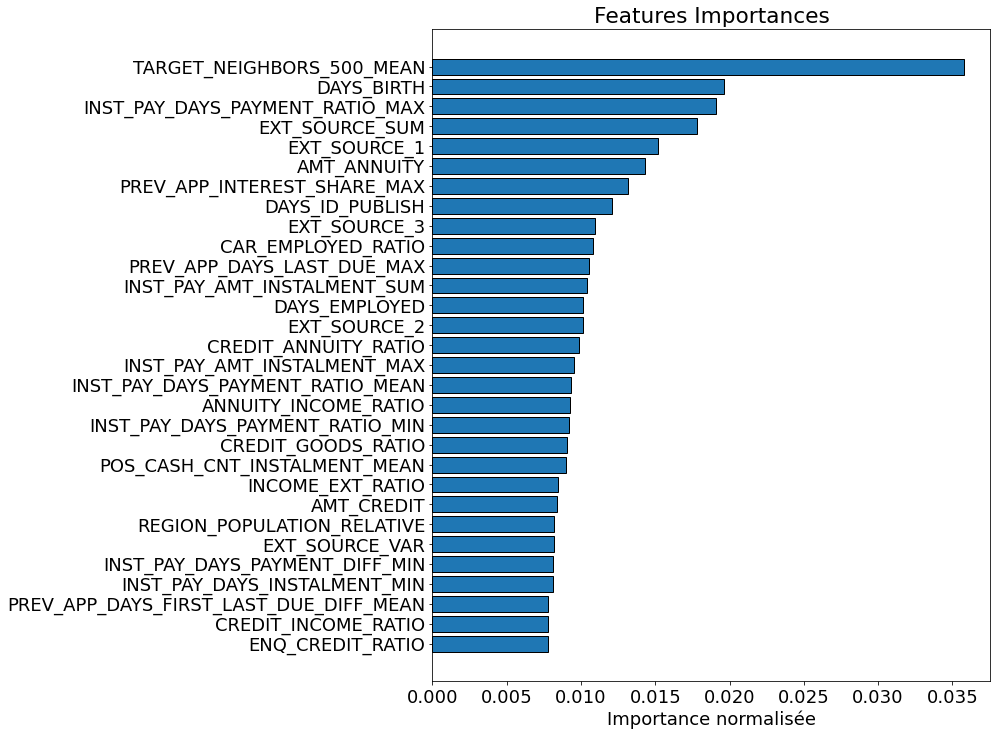

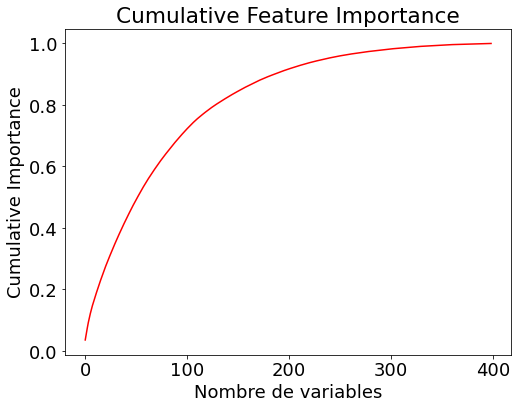

187 variables nécessaires pour 0.90 de cumulative importance


In [40]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_lightgbm_norm_4 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_lightgbm_4)

**Reconstitution des dataframes**

In [41]:
train_fs_lgbm['TARGET'] = train_fs_lgbm_labels
train_fs_lgbm['SK_ID_CURR'] = train_fs_lgbm_ids
print(f'train_fs_lgbm : {train_fs_lgbm.shape}')
test_fs_lgbm['SK_ID_CURR'] = test_fs_lgbm_ids
print(f'test_fs_lgbm : {test_fs_lgbm.shape}')

train_fs_lgbm : (307507, 401)
test_fs_lgbm : (48744, 400)


**Sauvegarde**

In [42]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_lightgbm = \
    'OUTPUT_DATA/fs_lightgbm.pickle'
with open(fic_sav_fs_lightgbm, 'wb') as f:
    pickle.dump(df_fs_lightgbm_4, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [43]:
# Chargement des features importance de ligthgbm
fic_sav_fs_train_set = \
    'OUTPUT_DATA/fs_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_train_set, 'rb') as df_fs_train_set:
    df_fs_lightgbm = pickle.load(df_fs_train_set)
df_fs_lightgbm.shape

(399, 2)

In [44]:
# Sauvegarde du nombre de features importance
df_fs_train_set = pd.DataFrame({})
df_fs_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_lightgbm,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'lightgbm')

train_set - lightgbm : 399 variables importantes conservées


<span>**Train_imp1_set/test_imp1_set**</span>

**Préparation des dataframes de travail**

In [45]:
# Résumé des variables qualitatives
desc_train_imp1_set = outils_data.description_variables(train_imp1_set)
desc_train_imp1_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,CREDIT_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MUL,EXT_SOURCE_MAX,EXT_SOURCE_VAR,INCOME_APARTMENT_AVG_MUL,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_TYPE_SUITE_XNA,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,...,PREV_APP_PRODUCT_COMBINATION_POS_HOUSEHOLD_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_OTHERS_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_OTHERS_WITHOUT_INTEREST_MEAN,PREV_APP_AMT_ANNUITY_MEAN,PREV_APP_AMT_ANNUITY_SUM,PREV_APP_AMT_ANNUITY_MIN,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_MIN,PREV_APP_AMT_DOWN_PAYMENT_MEAN,PREV_APP_AMT_GOODS_PRICE_MIN,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,PREV_APP_FLAG_LAST_APPL_PER_CONTRACT_MEAN,PREV_APP_NFLAG_LAST_APPL_IN_DAY_MEAN,PREV_APP_RATE_DOWN_PAYMENT_MEAN,PREV_APP_NAME_CONTRACT_STATUS_MEAN,PREV_APP_NAME_CONTRACT_STATUS_LAST,PREV_APP_DAYS_DECISION_MEAN,PREV_APP_DAYS_DECISION_MAX,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_SELLERPLACE_AREA_MIN,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_NAME_YIELD_GROUP_MEAN,PREV_APP_NAME_YIELD_GROUP_LAST,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM,PREV_APP_AMT_DECLINED_MEAN,PREV_APP_AMT_DECLINED_SUM,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM,PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_LOAN_RATE_MAX,PREV_APP_LOAN_RATE_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,PREV_APP_AMT_INTEREST_MEAN,PREV_APP_INTEREST_SHARE_MEAN,PREV_APP_INTEREST_SHARE_MAX,PREV_APP_INT

In [46]:
# Dataframes de travail
train_imp1_fs_lgbm = train_imp1_set.copy()
print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
test_imp1_fs_lgbm = test_imp1_set.copy()
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 597)
test_imp1_fs_lgbm : (48744, 655)


In [47]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_imp1_fs_lgbm_labels = train_imp1_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_imp1_fs_lgbm_ids = train_imp1_fs_lgbm['SK_ID_CURR']
test_imp1_fs_lgbm_ids = test_imp1_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_imp1_fs_lgbm, test_imp1_fs_lgbm = \
    train_imp1_fs_lgbm.align(test_imp1_fs_lgbm, join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_imp1_fs_lgbm = train_imp1_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_imp1_fs_lgbm = test_imp1_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 595)
test_imp1_fs_lgbm : (48744, 595)


**Modélisation**

***Premier passage***

In [48]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_imp1 = np.zeros(train_imp1_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [49]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_imp1_features, valid_imp1_features, train_imp1_y, valid_imp1_y = \
        train_test_split(train_imp1_fs_lgbm, train_imp1_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_imp1_features, train_imp1_y,
              early_stopping_rounds=100,
              eval_set=[(valid_imp1_features, valid_imp1_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances_imp1 += model.feature_importances_

[200]	valid_0's auc: 0.79338	valid_0's binary_logloss: 0.50564
[200]	valid_0's auc: 0.787813	valid_0's binary_logloss: 0.504971


In [50]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances_imp1 = feature_importances_imp1 / 2
df_fs_imp1_lightgbm = \
    pd.DataFrame({'feature': list(train_imp1_fs_lgbm.columns),
                  'importance': feature_importances_imp1}) \
    .sort_values('importance', ascending=False)

df_fs_imp1_lightgbm.head()

,feature,importance
87,TARGET_NEIGHBORS_500_MEAN,181.0
9,DAYS_BIRTH,106.0
27,EXT_SOURCE_2,95.0
261,INST_PAY_DAYS_PAYMENT_RATIO_MAX,94.5
10,DAYS_EMPLOYED,73.5


In [51]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features_imp1 = \
    list(df_fs_imp1_lightgbm[df_fs_imp1_lightgbm['importance'] == 0.0][
    'feature'])
print(f'{len(zero_features_imp1)} variables avec 0.0 importance :\n')
zero_features_imp1

173 variables avec 0.0 importance :



['PREV_APP_NAME_SELLER_INDUSTRY_MLM_PARTNERS_MEAN',
 'PREV_APP_NAME_SELLER_INDUSTRY_TOURISM_MEAN',
 'PREV_APP_NAME_SELLER_INDUSTRY_MLM_PARTNERS_SUM',
 'PREV_APP_NAME_SELLER_INDUSTRY_TOURISM_SUM',
 'ORGANIZATION_TYPE_CLEANING',
 'NAME_INCOME_TYPE_BUSINESSMAN',
 'BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SUM',
 'BUREAU_CREDIT_ACTIVE_BAD_DEBT_SUM',
 'BUREAU_CREDIT_ACTIVE_SOLD_SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_2_SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_3_SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_3_MEAN',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM',
 'BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM',
 'BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM',
 'FLAG_MOBIL',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT_SUM',
 'FLAG_CONT_MOBILE',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_PURCHASE_OF_SHARES_MARGIN_LENDING__SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_THE_PURCHASE_OF_EQUIPMENT_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_THE_PURCHASE_OF_EQUIPMENT_MEAN',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT_SUM',


5:5: E122 continuation line missing indentation or outdented


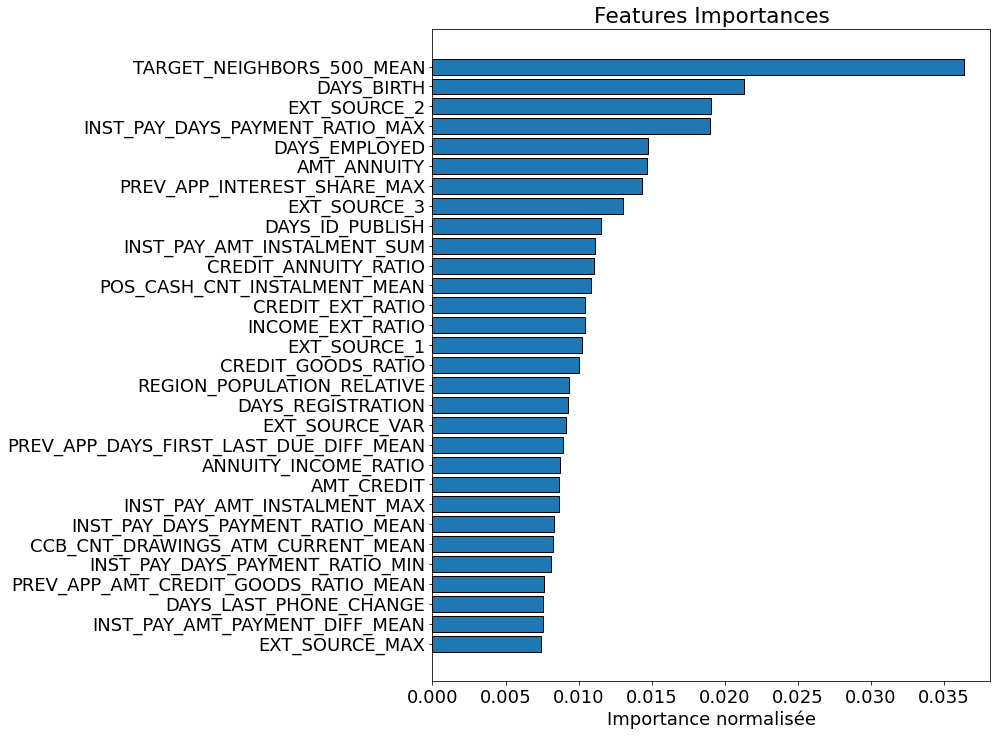

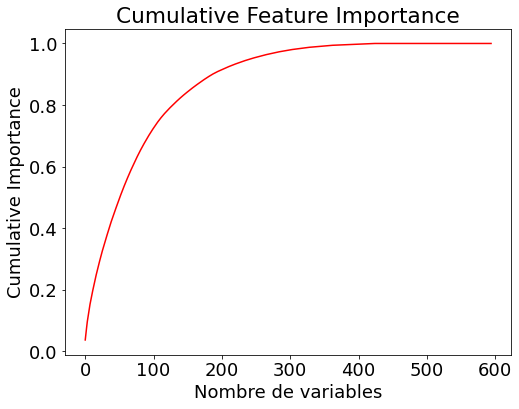

188 variables nécessaires pour 0.90 de cumulative importance


In [52]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp1_lightgbm_norm = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp1_lightgbm)

In [53]:
# Suppression des variables avec zéro importance
train_imp1_fs_lgbm = train_imp1_fs_lgbm.drop(columns=zero_features_imp1)
test_imp1_fs_lgbm = test_imp1_fs_lgbm.drop(columns=zero_features_imp1)

print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 422)
test_imp1_fs_lgbm : (48744, 422)


***Second passage***

In [54]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp1_2, df_fs_imp1_lightgbm_2 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp1_fs_lgbm,
                                       train_imp1_fs_lgbm_labels)

[200]	valid_0's auc: 0.792472	valid_0's binary_logloss: 0.506319
[200]	valid_0's auc: 0.789064	valid_0's binary_logloss: 0.504575

There are 19 features with 0.0 importance


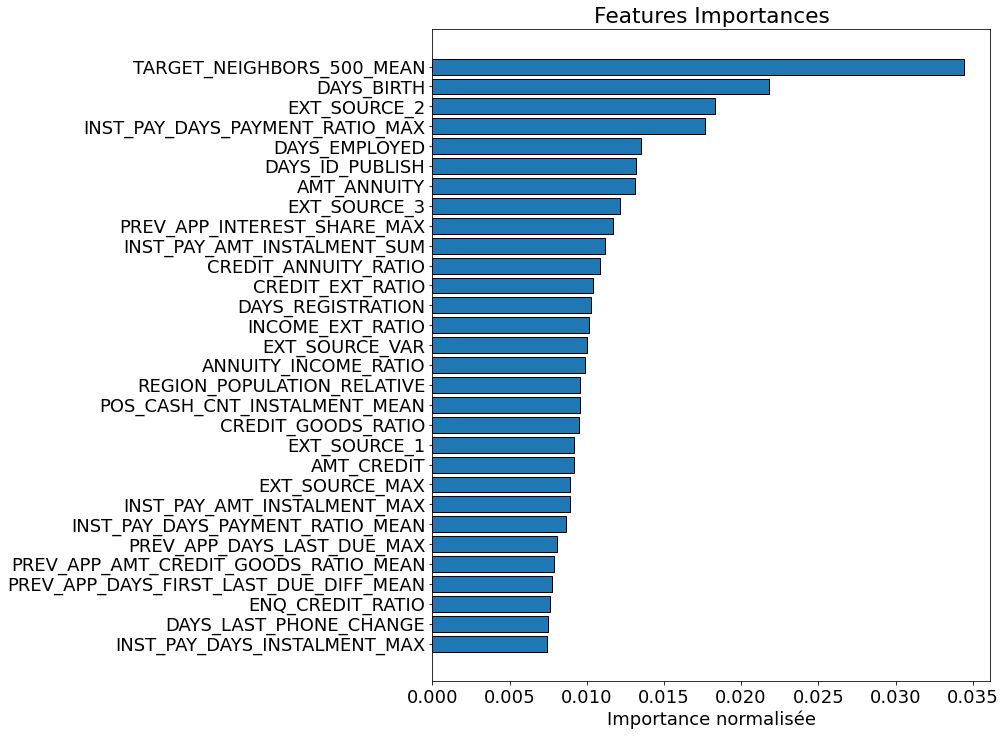

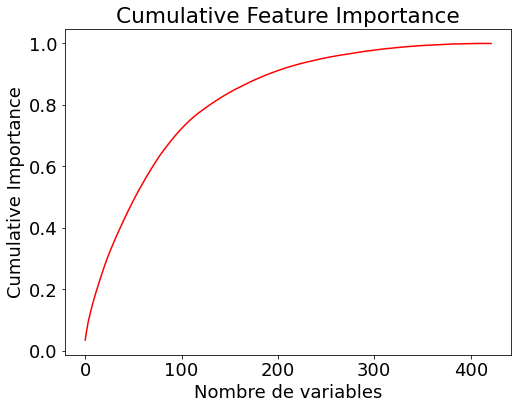

191 variables nécessaires pour 0.90 de cumulative importance


In [55]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp1_lightgbm_norm_2 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp1_lightgbm_2)

In [56]:
# Suppression des variables avec zéro importance
train_imp1_fs_lgbm = train_imp1_fs_lgbm.drop(columns=zero_features_imp1_2)
test_imp1_fs_lgbm = test_imp1_fs_lgbm.drop(columns=zero_features_imp1_2)

print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 403)
test_imp1_fs_lgbm : (48744, 403)


***Troisième passage***

In [57]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp1_3, df_fs_imp1_lightgbm_3 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp1_fs_lgbm,
                                       train_imp1_fs_lgbm_labels)

[200]	valid_0's auc: 0.792472	valid_0's binary_logloss: 0.506319
[200]	valid_0's auc: 0.788985	valid_0's binary_logloss: 0.504758

There are 0 features with 0.0 importance


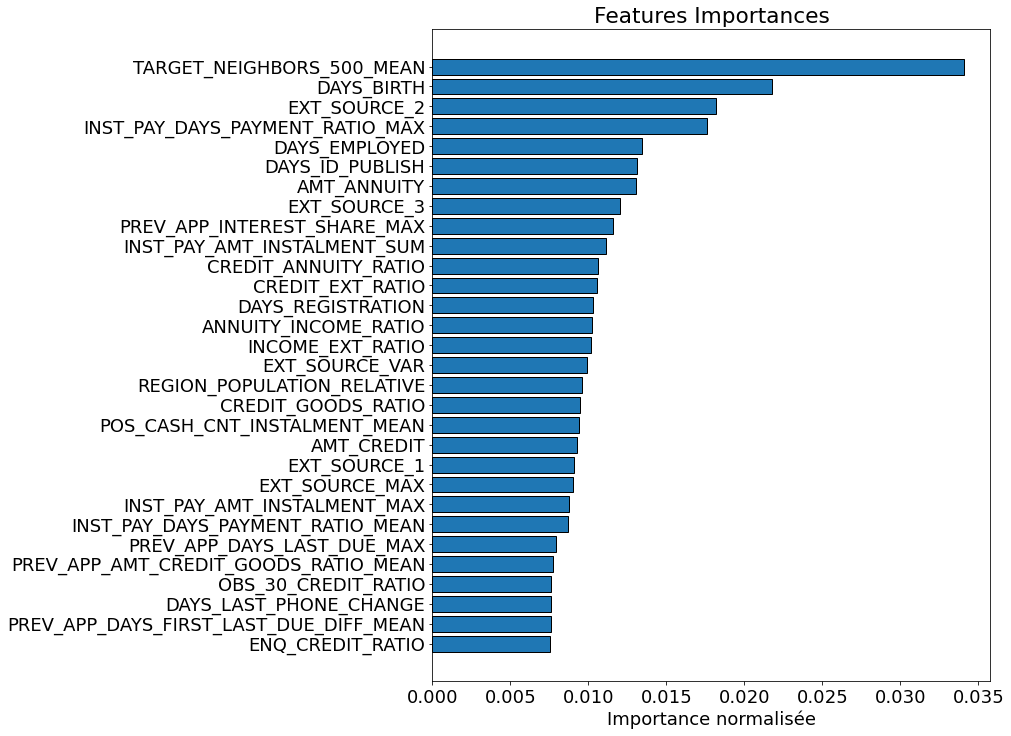

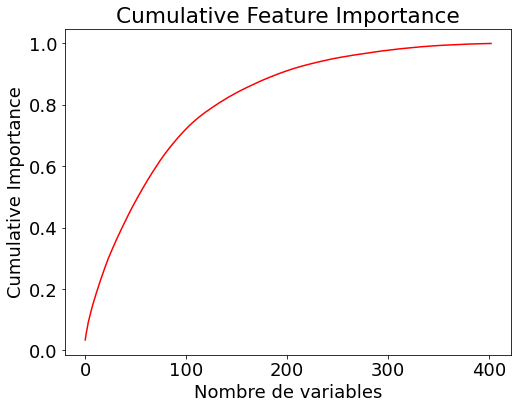

192 variables nécessaires pour 0.90 de cumulative importance


In [58]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp1_lightgbm_norm_3 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp1_lightgbm_3)

**Reconstitution des dataframes**

In [59]:
train_imp1_fs_lgbm['TARGET'] = train_imp1_fs_lgbm_labels
train_imp1_fs_lgbm['SK_ID_CURR'] = train_imp1_fs_lgbm_ids
print(f'train_imp1_fs_lgbm : {train_imp1_fs_lgbm.shape}')
test_imp1_fs_lgbm['SK_ID_CURR'] = test_imp1_fs_lgbm_ids
print(f'test_imp1_fs_lgbm : {test_imp1_fs_lgbm.shape}')

train_imp1_fs_lgbm : (307507, 405)
test_imp1_fs_lgbm : (48744, 404)


**Sauvegarde**

In [60]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_imp1_lightgbm = \
    'OUTPUT_DATA/fs_imp1_lightgbm.pickle'
with open(fic_sav_fs_imp1_lightgbm, 'wb') as f:
    pickle.dump(df_fs_imp1_lightgbm_3, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [61]:
# Chargement des features importance de ligthgbm
fic_sav_fs_train_imp1_set = \
    'OUTPUT_DATA/fs_imp1_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_train_imp1_set, 'rb') as df_fs_train_imp1_set:
    df_fs_imp1_lightgbm = pickle.load(df_fs_train_imp1_set)
df_fs_imp1_lightgbm.shape

(403, 2)

In [62]:
# Sauvegarde du nombre de features importance
df_fs_train_imp1_set = pd.DataFrame({})
df_fs_train_imp1_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp1_lightgbm,
                                                    df_fs_train_imp1_set,
                                                    'train_imp1_set',
                                                    'lightgbm')

train_imp1_set - lightgbm : 403 variables importantes conservées


<span>**Train_imp2_set/test_imp2_set**</span>

**Préparation des dataframes de travail**

In [63]:
# Résumé des variables qualitatives
desc_train_imp2_set = outils_data.description_variables(train_imp2_set)
desc_train_imp2_set

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,AGE_EMPLOYED_DIFF,LAST_PHONE_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MEAN,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_GROUP_OF_PEOPLE,NAME_TYPE_SUITE_OTHER_A,NAME_TYPE_SUITE_OTHER_B,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_TYPE_SUITE_XNA,NAME_INCOME_TYPE_BUSINESSMAN,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,...,PREV_APP_PRODUCT_COMBINATION_POS_HOUSEHOLD_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_HOUSEHOLD_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_OTHER_WITH_INTEREST_MEAN,PREV_APP_PRODUCT_COMBINATION_POS_OTHERS_WITHOUT_INTEREST_SUM,PREV_APP_PRODUCT_COMBINATION_POS_OTHERS_WITHOUT_INTEREST_MEAN,PREV_APP_AMT_ANNUITY_MEAN,PREV_APP_AMT_ANNUITY_SUM,PREV_APP_AMT_ANNUITY_MIN,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_MIN,PREV_APP_AMT_DOWN_PAYMENT_MEAN,PREV_APP_AMT_GOODS_PRICE_MIN,PREV_APP_HOUR_APPR_PROCESS_START_MEAN,PREV_APP_FLAG_LAST_APPL_PER_CONTRACT_MEAN,PREV_APP_NFLAG_LAST_APPL_IN_DAY_MEAN,PREV_APP_RATE_DOWN_PAYMENT_MEAN,PREV_APP_NAME_CONTRACT_STATUS_MEAN,PREV_APP_NAME_CONTRACT_STATUS_LAST,PREV_APP_DAYS_DECISION_MEAN,PREV_APP_DAYS_DECISION_MAX,PREV_APP_SELLERPLACE_AREA_MEAN,PREV_APP_SELLERPLACE_AREA_MIN,PREV_APP_CNT_PAYMENT_MEAN,PREV_APP_NAME_YIELD_GROUP_MEAN,PREV_APP_NAME_YIELD_GROUP_LAST,PREV_APP_DAYS_FIRST_DUE_SUM,PREV_APP_DAYS_LAST_DUE_MAX,PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM,PREV_APP_AMT_DECLINED_MEAN,PREV_APP_AMT_DECLINED_SUM,PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN,PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX,PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN,PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM,PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN,PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN,PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN,PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN,PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN,PREV_APP_ANNUITY_MEAN,PREV_APP_ANNUITY_GOODS_MEAN,PREV_APP_LOAN_RATE_MAX,PREV_APP_LOAN_RATE_MEAN,PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN,PREV_APP_AMT_

In [64]:
# Dataframes de travail
train_imp2_fs_lgbm = train_imp2_set.copy()
print(f'train_fs_lgbm : {train_imp2_fs_lgbm.shape}')
test_imp2_fs_lgbm = test_imp2_set.copy()
print(f'test_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_fs_lgbm : (307507, 592)
test_fs_lgbm : (48744, 631)


In [65]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_imp2_fs_lgbm_labels = train_imp2_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_imp2_fs_lgbm_ids = train_imp2_fs_lgbm['SK_ID_CURR']
test_imp2_fs_lgbm_ids = test_imp2_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_imp2_fs_lgbm, test_im2_fs_lgbm = \
    train_imp2_fs_lgbm.align(test_imp2_fs_lgbm, join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_imp2_fs_lgbm = train_imp2_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_imp2_fs_lgbm = test_imp2_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 590)
test_imp2_fs_lgbm : (48744, 630)


**Modélisation**

***Premier passage***

In [66]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_imp2 = np.zeros(train_imp2_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [67]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_imp2_features, valid_imp2_features, train_imp2_y, valid_imp2_y = \
        train_test_split(train_imp2_fs_lgbm, train_imp2_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_imp2_features, train_imp2_y,
              early_stopping_rounds=100,
              eval_set=[(valid_imp2_features, valid_imp2_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances_imp2 += model.feature_importances_

[200]	valid_0's auc: 0.792233	valid_0's binary_logloss: 0.506507
[200]	valid_0's auc: 0.788137	valid_0's binary_logloss: 0.503251


In [68]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances_imp2 = feature_importances_imp2 / 2
df_fs_imp2_lightgbm = \
    pd.DataFrame({'feature': list(train_imp2_fs_lgbm.columns),
                  'importance': feature_importances_imp2}) \
    .sort_values('importance', ascending=False)

df_fs_imp2_lightgbm.head()

,feature,importance
85,TARGET_NEIGHBORS_500_MEAN,141.0
79,EXT_SOURCE_MEAN,89.0
259,INST_PAY_DAYS_PAYMENT_RATIO_MAX,87.5
9,DAYS_BIRTH,82.5
73,INCOME_EXT_RATIO,72.5


In [69]:
# Exploration des variables avec zéro importance
# Find the features with zero importance
zero_features_imp2 = \
    list(df_fs_imp2_lightgbm[df_fs_imp2_lightgbm['importance'] == 0.0][
    'feature'])
print(f'{len(zero_features_imp2)} variables avec 0.0 importance :\n')
zero_features_imp2

199 variables avec 0.0 importance :



['FLAG_EMP_PHONE',
 'BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SUM',
 'BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM',
 'FLAG_CONT_MOBILE',
 'BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_MEAN',
 'NAME_TYPE_SUITE_GROUP_OF_PEOPLE',
 'PREV_APP_NAME_SELLER_INDUSTRY_INDUSTRY_SUM',
 'NAME_INCOME_TYPE_XNA',
 'NAME_INCOME_TYPE_UNEMPLOYED',
 'NAME_INCOME_TYPE_STUDENT',
 'FLAG_DOCUMENT_14',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT_MEAN',
 'BUREAU_CREDIT_TYPE_UNKNOWN_TYPE_OF_LOAN_SUM',
 'BUREAU_CREDIT_TYPE_REAL_ESTATE_LOAN_MEAN',
 'NAME_TYPE_SUITE_XNA',
 'BUREAU_CREDIT_TYPE_REAL_ESTATE_LOAN_SUM',
 'PREV_APP_NAME_CONTRACT_STATUS_LAST',
 'BUREAU_CREDIT_TYPE_MOBILE_OPERATOR_LOAN_SUM',
 'NAME_INCOME_TYPE_BUSINESSMAN',
 'CNT_CHILDREN',
 'FLAG_MOBIL',
 'NAME_TYPE_SUITE_OTHER_A',
 'BUREAU_CREDIT_TYPE_ANOTHER_TYPE_OF_LOAN_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT_SUM',
 'PREV_APP_NAME_SELLER_INDUSTRY_AUTO_TECHNOLOGY_SUM',
 

5:5: E122 continuation line missing indentation or outdented


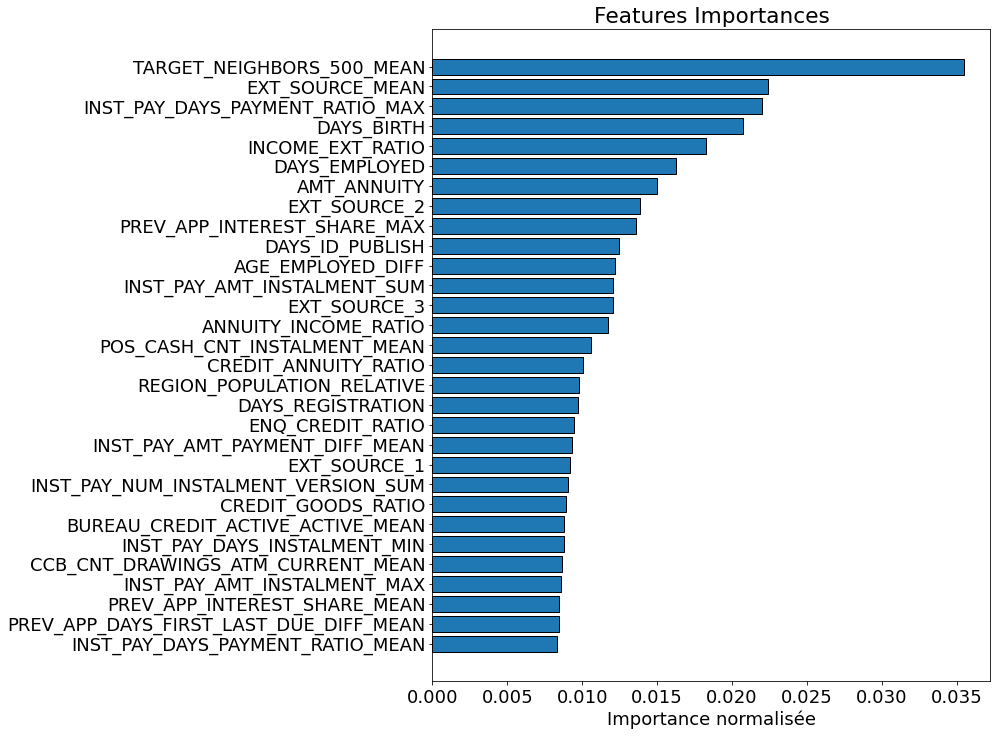

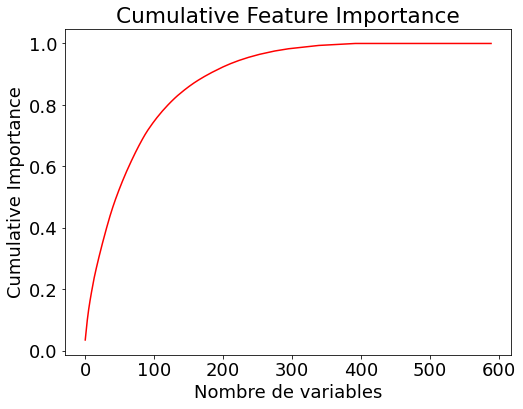

180 variables nécessaires pour 0.90 de cumulative importance


In [70]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp2_lightgbm_norm = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp2_lightgbm)

In [71]:
# Suppression des variables avec zéro importance
train_imp2_fs_lgbm = train_imp2_fs_lgbm.drop(columns=zero_features_imp2)
test_imp2_fs_lgbm = test_imp2_fs_lgbm.drop(columns=zero_features_imp2)

print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 391)
test_imp2_fs_lgbm : (48744, 431)


***Second passage***

In [72]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp2_2, df_fs_imp2_lightgbm_2 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp2_fs_lgbm,
                                       train_imp2_fs_lgbm_labels)

[200]	valid_0's auc: 0.792124	valid_0's binary_logloss: 0.505168
[200]	valid_0's auc: 0.78875	valid_0's binary_logloss: 0.504088

There are 32 features with 0.0 importance


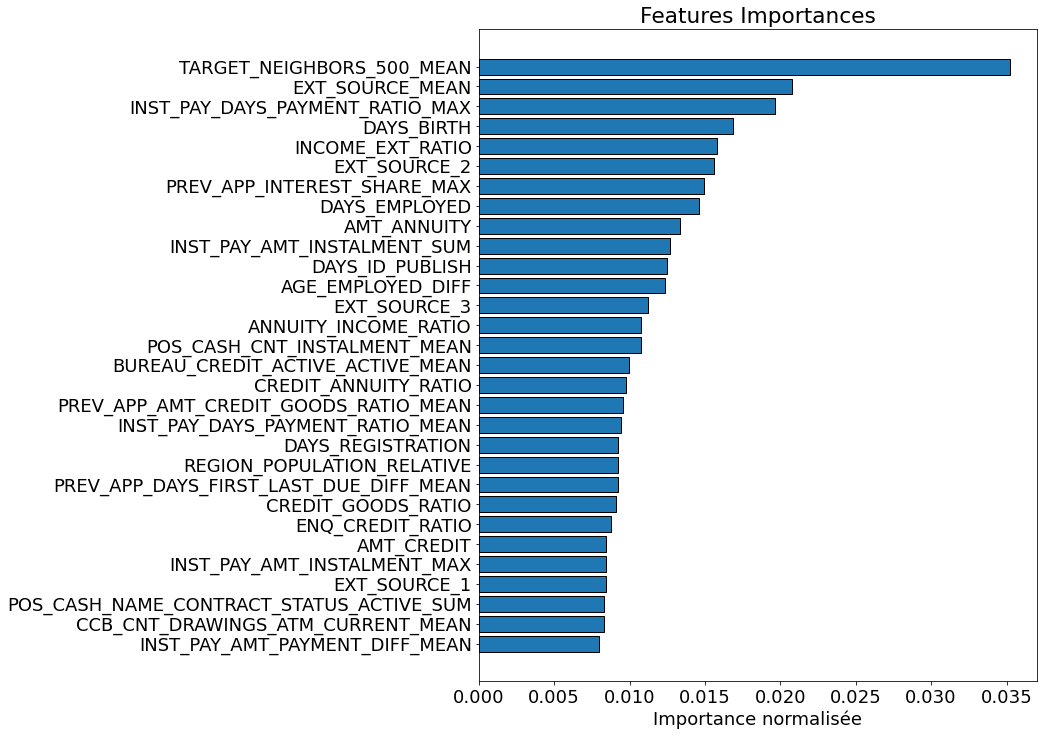

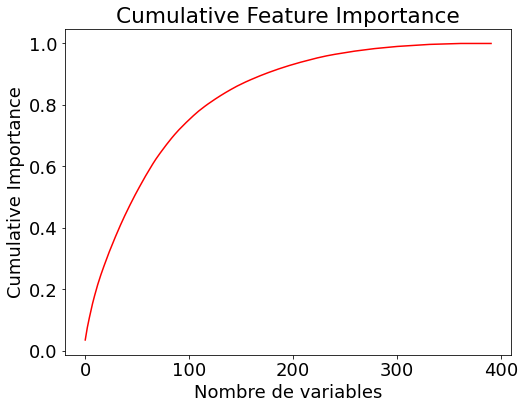

173 variables nécessaires pour 0.90 de cumulative importance


In [73]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp2_lightgbm_norm_2 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp2_lightgbm_2)

In [74]:
# Suppression des variables avec zéro importance
train_imp2_fs_lgbm = train_imp2_fs_lgbm.drop(columns=zero_features_imp2_2)
test_imp2_fs_lgbm = test_imp2_fs_lgbm.drop(columns=zero_features_imp2_2)

print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 359)
test_imp2_fs_lgbm : (48744, 399)


***Troisième passage***

In [75]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_imp2_3, df_fs_imp2_lightgbm_3 = eda_kernel_fonctions \
    .identify_zero_importance_features(train_imp2_fs_lgbm,
                                       train_imp2_fs_lgbm_labels)

[200]	valid_0's auc: 0.79174	valid_0's binary_logloss: 0.505722
[200]	valid_0's auc: 0.789543	valid_0's binary_logloss: 0.503231

There are 12 features with 0.0 importance


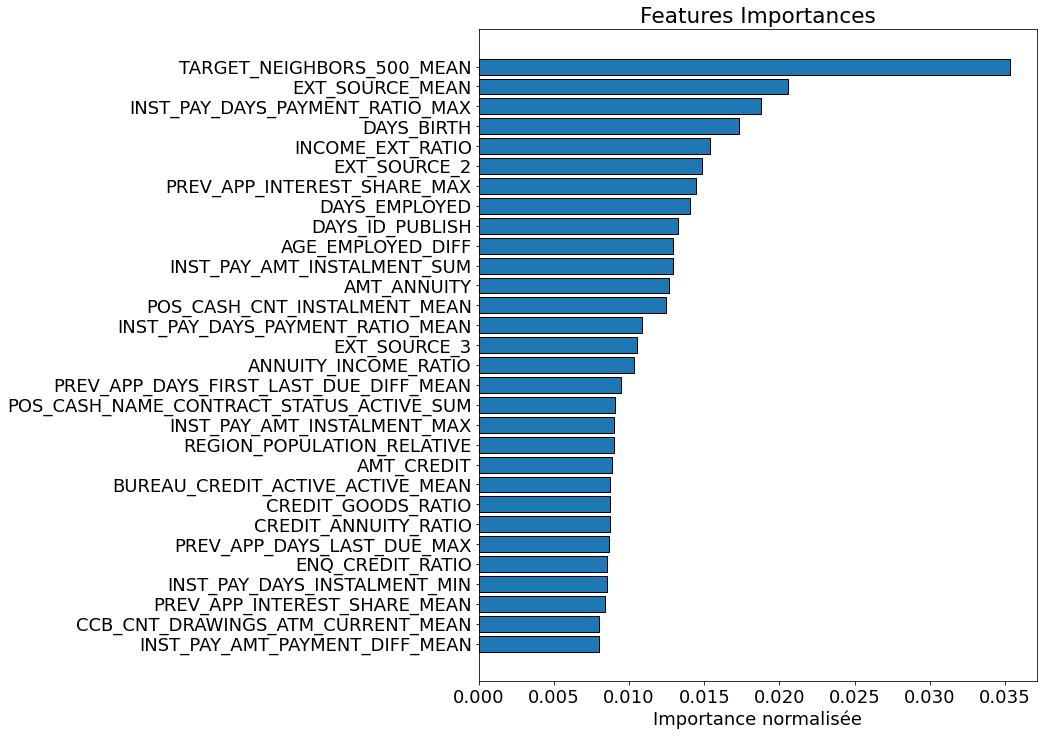

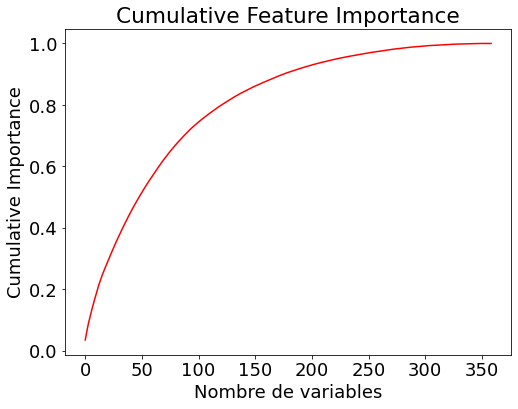

176 variables nécessaires pour 0.90 de cumulative importance


In [76]:
# Affichage des variables les plus importantes normalisées déterminée
# par Lightgbm
df_fs_imp2_lightgbm_norm_3 = \
    eda_kernel_fonctions.plot_feature_importances(df_fs_imp2_lightgbm_3)

**Reconstitution des dataframes**

In [77]:
train_imp2_fs_lgbm['TARGET'] = train_imp2_fs_lgbm_labels
train_imp2_fs_lgbm['SK_ID_CURR'] = train_imp2_fs_lgbm_ids
print(f'train_imp2_fs_lgbm : {train_imp2_fs_lgbm.shape}')
test_imp2_fs_lgbm['SK_ID_CURR'] = test_imp2_fs_lgbm_ids
print(f'test_imp2_fs_lgbm : {test_imp2_fs_lgbm.shape}')

train_imp2_fs_lgbm : (307507, 361)
test_imp2_fs_lgbm : (48744, 400)


**Sauvegarde**

In [78]:
# Sauvegarde des features importances avec lightgbm
fic_sav_fs_imp2_lightgbm = \
    'OUTPUT_DATA/fs_imp2_lightgbm.pickle'
with open(fic_sav_fs_imp2_lightgbm, 'wb') as f:
    pickle.dump(df_fs_imp2_lightgbm_3, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [79]:
# Chargement des features importance de ligthgbm
fic_sav_fs_train_imp2_set = \
    'OUTPUT_DATA/fs_imp2_lightgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_train_imp2_set, 'rb') as df_fs_train_imp2_set:
    df_fs_imp2_lightgbm = pickle.load(df_fs_train_imp2_set)
df_fs_imp2_lightgbm.shape

(359, 2)

In [80]:
# Sauvegarde du nombre de features importance
df_fs_train_imp2_set = pd.DataFrame({})
df_fs_train_imp2_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp2_lightgbm,
                                                    df_fs_train_imp2_set,
                                                    'train_imp2_set',
                                                    'lightgbm')

train_imp2_set - lightgbm : 359 variables importantes conservées


### <span>3.2. Features selection : avec BORUTA</span>

- Extrait du Kernel Kaggle de Robert Smith : [Source](https://www.kaggle.com/rsmits/feature-selection-with-boruta)

Boruta, comme RFE, est une technique de sélection de caractéristiques basée sur des enveloppes. Elle est moins connue mais tout aussi puissante. L'idée derrière Boruta est très simple. Étant donné un ensemble de données tabulaires, nous ajustons itérativement un algorithme supervisé (généralement un modèle basé sur un arbre) sur une version étendue des données. La version étendue, à chaque itération, est composée des données d'origine avec, attachée horizontalement, une copie des colonnes mélangées. Nous ne conservons que les caractéristiques qui, dans chaque itération :
ont une plus grande importance que la meilleure des caractéristiques mélangées ;
sont meilleures que prévu par rapport au hasard (en utilisant une distribution binomiale).

- Boruta : [Source](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a) [Source](https://towardsdatascience.com/boruta-and-shap-for-better-feature-selection-20ea97595f4a) [Source](https://blog.exploratory.io/finding-variable-importance-with-random-forest-boruta-28badd116197) [Source](https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a)

<span>**Train_set / test_set**</span>

<span>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

***Avec model RandomForestClassifier***

**Préparation du dataframe de travail**

In [81]:
# Dataframes de travail
train_fs_boruta = train_set.copy()
print(f'train_fs_boruta : {train_fs_boruta.shape}')

train_fs_boruta : (307507, 590)


In [82]:
# Sauvegarde des étiquettes
train_fs_boruta_labels = train_fs_boruta['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_boruta = train_fs_boruta.drop(columns=['SK_ID_CURR'])
train_fs_boruta = train_fs_boruta.drop(columns=['TARGET'])

print(f'train_fs_boruta : {train_fs_boruta.shape}')

train_fs_boruta : (307507, 588)


In [83]:
# Initialisation des variables
X = train_fs_boruta.values
y = train_fs_boruta_labels.values.ravel()

- Ensuite, nous configurons le RandomForestClassifier comme estimateur
à utiliser pour Boruta.
- Le max_depth de l'arbre est conseillé sur la page Github de Boruta pour
être entre 3 et 7.

In [84]:
rf = RandomForestClassifier(n_jobs=-1,
                            class_weight='balanced',
                            max_depth=5)

- Ensuite, nous configurons Boruta.
    - Il utilise l'interface scikit-learn autant que possible, donc nous pouvons utiliser fit(X, y), transform(X), fit_transform(X, y).
    - Je le laisse tourner pour un maximum de max_iter = 50 itérations.
    - Avec perc = 90, un seuil est spécifié.
    - Plus le seuil est bas, plus de caractéristiques seront sélectionnées.
    - J'utilise généralement un pourcentage entre 80 et 90.

In [85]:
# Initialisation de Boruta
boruta_feature_selector = BorutaPy(rf,
                                   n_estimators='auto',
                                   verbose=2,
                                   random_state=21,
                                   max_iter=50,
                                   perc=90)
# Entraînement
boruta_feature_selector.fit(X, y)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	216
Tentative: 	65
Rejected: 	307
Iteration: 	9 / 50
Confirmed: 	216
Tentative: 	65
Rejected: 	307
Iteration: 	10 / 50
Confirmed: 	216
Tentative: 	65
Rejected: 	307
Iteration: 	11 / 50
Confirmed: 	216
Tentative: 	65
Rejected: 	307
Iteration: 	12 / 50
Confirmed: 	218
Tentative: 	63
Rejected: 	307
Iteration: 	13 / 50
Confirmed: 	218
Tentative: 	52
Rejected: 	318
Iteration: 	14 / 50
Confirmed: 	218
Tentative: 	52
Rejected: 	318
Iteration: 	15 / 50
Confirmed: 	218
Tentative: 	52
Rejected: 	318
Iteration: 	16 / 50
Confirmed: 	218
Tent

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=432, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x23F3B07B640),
         max_iter=50, n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x23F3B07B640, verbose=2)

In [86]:
# On applique le modèle sur le dataset
X_filtered = boruta_feature_selector.transform(X)
X_filtered.shape

(307507, 219)

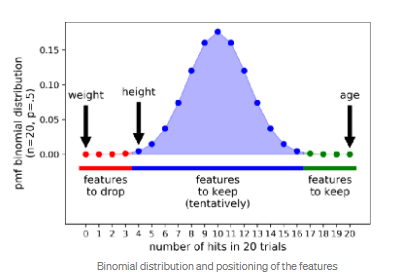

In [87]:
# Liste des variables confirmées avec une haute importance
%pycodestyle_off
fs_boruta = list()
features = [f for f in train_fs_boruta.columns]
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    fs_boruta.append(features[x])
display(f'fs_boruta : {fs_boruta}')
%pycodestyle_on

"fs_boruta : ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'NONLIVINGAREA_AVG', 'EMERGENCYSTATE_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'CREDIT_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_GOODS_RATIO', 'INCOME_GOODS_DIFF', 'INCOME_EXT_RATIO', 'LAST_PHONE_EMPLOYED_RATIO', 'CAR_EMPLOYED_RATIO', 'FLAG_CONTACTS_SUM', 'EXT_SOURCE_SUM', 'EXT_SOURCE_MAX', 'EXT_SOURCE_VAR', 'OBS_DEF_30_MUL', 'OBS_30_CRE

In [88]:
# Dataframe de features importance avec boruta
df_fs_boruta = pd.DataFrame(fs_boruta)

**Sauvegarde**

In [89]:
# Sauvegarde des features importances avec boruta
fic_sav_fs_boruta = \
    'OUTPUT_DATA/fs_boruta.pickle'
with open(fic_sav_fs_boruta, 'wb') as f:
    pickle.dump(df_fs_boruta, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [90]:
# Chargement des features importance de boruta
fic_sav_fs_boruta = \
    'OUTPUT_DATA/fs_boruta.pickle'
# Chargement des features importance
with open(fic_sav_fs_boruta, 'rb') as df_fs_boruta:
    df_fs_boruta = pickle.load(df_fs_boruta)
df_fs_boruta.shape

(219, 1)

In [91]:
# Sauvegarde du nombre de features importance
df_fs_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_boruta,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'boruta-RandomForest')

train_set - boruta-RandomForest : 219 variables importantes conservées


***Avec model Lightgbm***

- En utilisant une classe spécifique suite à l'erreur 'num_boost_round' ne peut pas être nulle.

**Préparation du dataframe de travail**

In [92]:
# Dataframes de travail
train_fs_boruta_lgbm = train_set.copy()
print(f'train_fs_boruta_lgbm : {train_fs_boruta_lgbm.shape}')

train_fs_boruta_lgbm : (307507, 590)


In [93]:
# Sauvegarde des étiquettes
train_fs_boruta_lgbm_labels = train_fs_boruta_lgbm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_boruta_lgbm = train_fs_boruta_lgbm.drop(columns=['SK_ID_CURR'])
train_fs_boruta_lgbm = train_fs_boruta_lgbm.drop(columns=['TARGET'])

print(f'train_fs_boruta_lgbm : {train_fs_boruta_lgbm.shape}')

train_fs_boruta_lgbm : (307507, 588)


In [94]:
# Initialisation des variables
X = train_fs_boruta_lgbm.values
y = train_fs_boruta_lgbm_labels.values.ravel()

In [95]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary',
                          boosting_type='goss',
                          n_estimators=10000,
                          class_weight='balanced',
                          num_boost_round=100)

- Ensuite, nous configurons Boruta.
    - Il utilise l'interface scikit-learn autant que possible, donc nous pouvons utiliser fit(X, y), transform(X), fit_transform(X, y).
    - Je le laisse tourner pour un maximum de max_iter = 50 itérations.
    - Avec perc = 90, un seuil est spécifié.
    - Plus le seuil est bas, plus de caractéristiques seront sélectionnées.
    - J'utilise généralement un pourcentage entre 80 et 90.

In [96]:
# Initialisation de Boruta
boruta_feature_selector_lgbm = \
    outils_preprocessing.BorutaPyForLGB(lgbm,
                                        n_estimators='auto',
                                        verbose=2,
                                        random_state=21,
                                        max_iter=50,
                                        perc=90)
# Entraînement
boruta_feature_selector_lgbm.fit(X, y)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	88
Tentative: 	70
Rejected: 	430
Iteration: 	9 / 50
Confirmed: 	88
Tentative: 	70
Rejected: 	430
Iteration: 	10 / 50
Confirmed: 	88
Tentative: 	70
Rejected: 	430
Iteration: 	11 / 50
Confirmed: 	88
Tentative: 	70
Rejected: 	430
Iteration: 	12 / 50
Confirmed: 	90
Tentative: 	57
Rejected: 	441
Iteration: 	13 / 50
Confirmed: 	90
Tentative: 	57
Rejected: 	441
Iteration: 	14 / 50
Confirmed: 	90
Tentative: 	57
Rejected: 	441
Iteration: 	15 / 50
Confirmed: 	90
Tentative: 	57
Rejected: 	441
Iteration: 	16 / 50
Confirmed: 	91
Tentative: 	4

BorutaPyForLGB(estimator=LGBMClassifier(boosting_type='goss',
                                        class_weight='balanced',
                                        n_estimators=-1456, num_boost_round=100,
                                        objective='binary', random_state=5342),
               max_iter=50, n_estimators='auto', perc=90,
               random_state=RandomState(MT19937) at 0x23F3B07B840, verbose=2)

In [97]:
# On applique le modèle sur le dataset
X_filtered_lgbm = boruta_feature_selector_lgbm.transform(X)
X_filtered_lgbm.shape

(307507, 92)

In [98]:
# Liste des variables confirmées avec une haute importance
%pycodestyle_off
fs_boruta_lgbm = list()
features_lgbm = [f for f in train_fs_boruta_lgbm.columns]
indexes_lgbm = np.where(boruta_feature_selector_lgbm.support_ == True)
for x in np.nditer(indexes_lgbm):
    fs_boruta_lgbm.append(features_lgbm[x])
display(f'fs_boruta_lgbm : {fs_boruta_lgbm}')
%pycodestyle_on

"fs_boruta_lgbm : ['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'CREDIT_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_GOODS_RATIO', 'INCOME_GOODS_DIFF', 'INCOME_EXT_RATIO', 'CAR_EMPLOYED_RATIO', 'EXT_SOURCE_SUM', 'EXT_SOURCE_MAX', 'EXT_SOURCE_VAR', 'OBS_30_CREDIT_RATIO', 'ENQ_CREDIT_RATIO', 'TARGET_NEIGHBORS_500_MEAN', 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION', 'NAME_FAMILY_STATUS_MARRIED', 'CCB_AMT_BALANCE_MEAN', 'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CCB_BALANCE_LIMIT_RATIO_MEAN', 'INST_PAY_NUM_INSTALMENT_VERSION_MEAN', 'INST_PAY_NUM_INSTALMENT_VERSION_SUM', 'INST_PAY_NUM_INSTALMENT_NUMBER_MAX', 'INST_PAY_DAYS_INSTALME

In [99]:
# Dataframe de features importance avec boruta
df_fs_boruta_lgbm = pd.DataFrame(fs_boruta_lgbm)

**Sauvegarde**

In [100]:
# Sauvegarde des features importances avec boruta
fic_sav_fs_boruta_lgbm = \
    'OUTPUT_DATA/fs_boruta_lgbm.pickle'
with open(fic_sav_fs_boruta_lgbm, 'wb') as f:
    pickle.dump(df_fs_boruta_lgbm, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [101]:
# Chargement des features importance de boruta
fic_sav_fs_boruta_lgbm = \
    'OUTPUT_DATA/fs_boruta_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_boruta_lgbm, 'rb') as df_fs_boruta_lgbm:
    df_fs_boruta_lgbm = pickle.load(df_fs_boruta_lgbm)
df_fs_boruta_lgbm.shape

(92, 1)

In [102]:
# Sauvegarde du nombre de features importance
df_fs_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_boruta_lgbm,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'boruta-LightGbm-1')

train_set - boruta-LightGbm-1 : 92 variables importantes conservées


***Avec model Lightgbm***

- En utilisant la classe non spécifique BorutaPy, en ajoutant 'num_boost_round' au modèle LightGbm, un warning est affiché mais plus l'erreur fatale.

**Préparation du dataframe de travail**

In [103]:
# Dataframes de travail
train_fs_boruta_lgbm2 = train_set.copy()
print(f'train_fs_boruta_lgbm2 : {train_fs_boruta_lgbm2.shape}')

train_fs_boruta_lgbm2 : (307507, 590)


In [104]:
# Sauvegarde des étiquettes
train_fs_boruta_lgbm2_labels = train_fs_boruta_lgbm2['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_boruta_lgbm2 = train_fs_boruta_lgbm2.drop(columns=['SK_ID_CURR'])
train_fs_boruta_lgbm2 = train_fs_boruta_lgbm2.drop(columns=['TARGET'])

print(f'train_fs_boruta_lgbm2 : {train_fs_boruta_lgbm2.shape}')

train_fs_boruta_lgbm2 : (307507, 588)


In [105]:
# Initialisation des variables
X = train_fs_boruta_lgbm2.values
y = train_fs_boruta_lgbm2_labels.values.ravel()

In [106]:
# Create the model with several hyperparameters
lgbm2 = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced',
                           num_boost_round=100)

- Ensuite, nous configurons Boruta.
    - Il utilise l'interface scikit-learn autant que possible, donc nous pouvons utiliser fit(X, y), transform(X), fit_transform(X, y).
    - Je le laisse tourner pour un maximum de max_iter = 50 itérations.
    - Avec perc = 90, un seuil est spécifié.
    - Plus le seuil est bas, plus de caractéristiques seront sélectionnées.
    - J'utilise généralement un pourcentage entre 80 et 90.

In [107]:
# Initialisation de Boruta
boruta_feature_selector_lgbm2 = BorutaPy(lgbm2,
                                         n_estimators='auto',
                                         verbose=2,
                                         random_state=21,
                                         max_iter=50,
                                         perc=90)
# Entraînement
boruta_feature_selector_lgbm2.fit(X, y)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	588
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	93
Tentative: 	80
Rejected: 	415
Iteration: 	9 / 50
Confirmed: 	93
Tentative: 	80
Rejected: 	415
Iteration: 	10 / 50
Confirmed: 	93
Tentative: 	80
Rejected: 	415
Iteration: 	11 / 50
Confirmed: 	93
Tentative: 	80
Rejected: 	415
Iteration: 	12 / 50
Confirmed: 	95
Tentative: 	58
Rejected: 	435
Iteration: 	13 / 50
Confirmed: 	95
Tentative: 	58
Rejected: 	435
Iteration: 	14 / 50
Confirmed: 	95
Tentative: 	58
Rejected: 	435
Iteration: 	15 / 50
Confirmed: 	95
Tentative: 	58
Rejected: 	435
Iteration: 	16 / 50
Confirmed: 	95
Tentative: 	4

BorutaPy(estimator=LGBMClassifier(boosting_type='goss', class_weight='balanced',
                                  n_estimators=-1469, num_boost_round=100,
                                  objective='binary',
                                  random_state=RandomState(MT19937) at 0x23F3B07B740),
         max_iter=50, n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x23F3B07B740, verbose=2)

In [108]:
# On applique le modèle sur le dataset
X_filtered_lgbm2 = boruta_feature_selector_lgbm2.transform(X)
X_filtered_lgbm2.shape

(307507, 95)

In [109]:
# Liste des variables confirmées avec une haute importance
#%pycodestyle_off
fs_boruta_lgbm2 = list()
features_lgbm2 = [f for f in train_fs_boruta_lgbm2.columns]
indexes_lgbm2 = np.where(boruta_feature_selector_lgbm2.support_ == True)
for x in np.nditer(indexes_lgbm2):
    fs_boruta_lgbm2.append(features_lgbm2[x])
display(f'fs_boruta_lgbm : {fs_boruta_lgbm2}')
%pycodestyle_on

"fs_boruta_lgbm : ['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'CREDIT_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_GOODS_RATIO', 'INCOME_GOODS_DIFF', 'INCOME_EXT_RATIO', 'CAR_EMPLOYED_RATIO', 'EXT_SOURCE_SUM', 'EXT_SOURCE_MAX', 'EXT_SOURCE_VAR', 'ENQ_CREDIT_RATIO', 'TARGET_NEIGHBORS_500_MEAN', 'NAME_INCOME_TYPE_WORKING', 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION', 'NAME_FAMILY_STATUS_MARRIED', 'CCB_AMT_BALANCE_MEAN', 'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CCB_BALANCE_LIMIT_RATIO_MEAN', 'INST_PAY_NUM_INSTALMENT_VERSION_MEAN', 'INST_PAY_NUM_INSTALMENT_VERSION_SUM', 'INST_PAY_NUM_INSTALMENT_NUMBER_MAX', 'INST_PAY_DAYS_INST

2:1: E265 block comment should start with '# '


ValueError: too many values to unpack (expected 3)

In [110]:
# Dataframe de features importance avec boruta
df_fs_boruta_lgbm2 = pd.DataFrame(fs_boruta_lgbm2)

**Sauvegarde**

In [111]:
# Sauvegarde des features importances avec boruta
fic_sav_fs_boruta_lgbm2 = \
    'OUTPUT_DATA/fs_boruta_lgbm2.pickle'
with open(fic_sav_fs_boruta_lgbm2, 'wb') as f:
    pickle.dump(df_fs_boruta_lgbm2, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [112]:
# Chargement des features importance de boruta
fic_sav_fs_boruta_lgbm2 = \
    'OUTPUT_DATA/fs_boruta_lgbm2.pickle'
# Chargement des features importance
with open(fic_sav_fs_boruta_lgbm2, 'rb') as df_fs_boruta_lgbm2:
    df_fs_boruta_lgbm2 = pickle.load(df_fs_boruta_lgbm2)
df_fs_boruta_lgbm2.shape

(95, 1)

In [113]:
# Sauvegarde du nombre de features importance
df_fs_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_boruta_lgbm2,
                                                    df_fs_train_set, 'train_set', 'boruta-LightGbm-2')

4:80: E501 line too long (102 > 79 characters)


<span>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

**Préparation du dataframe de travail**

In [114]:
# Dataframes de travail
train_fs_sans_boruta_lgbm = train_set.copy()
train_fs_sans_boruta_lgbm = \
    train_fs_sans_boruta_lgbm.drop(['TARGET_NEIGHBORS_500_MEAN'], axis=1)
print(f'train_fs_sans_boruta_lgbm : {train_fs_sans_boruta_lgbm.shape}')

In [115]:
# Sauvegarde des étiquettes
train_fs_sans_boruta_lgbm_labels = train_fs_sans_boruta_lgbm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_sans_boruta_lgbm =\
    train_fs_sans_boruta_lgbm.drop(columns=['SK_ID_CURR'])
train_fs_sans_boruta_lgbm = train_fs_sans_boruta_lgbm.drop(columns=['TARGET'])

print(f'train_fs_sans_boruta_lgbm : {train_fs_sans_boruta_lgbm.shape}')

In [116]:
# Initialisation des variables
X = train_fs_sans_boruta_lgbm.values
y = train_fs_sans_boruta_lgbm_labels.values.ravel()

In [117]:
# Create the model with several hyperparameters
lgbm_sans = lgb.LGBMClassifier(objective='binary',
                               boosting_type='goss',
                               n_estimators=10000,
                               class_weight='balanced',
                               num_boost_round=100)

- Ensuite, nous configurons Boruta.
    - Il utilise l'interface scikit-learn autant que possible, donc nous pouvons utiliser fit(X, y), transform(X), fit_transform(X, y).
    - Je le laisse tourner pour un maximum de max_iter = 50 itérations.
    - Avec perc = 90, un seuil est spécifié.
    - Plus le seuil est bas, plus de caractéristiques seront sélectionnées.
    - J'utilise généralement un pourcentage entre 80 et 90.

In [118]:
# Initialisation de Boruta
boruta_feature_selector_sans_lgbm = BorutaPy(lgbm_sans,
                                             n_estimators='auto',
                                             verbose=2,
                                             random_state=21,
                                             max_iter=50,
                                             perc=90)
# Entraînement
boruta_feature_selector_sans_lgbm.fit(X, y)

BorutaPy(estimator=LGBMClassifier(boosting_type='goss', class_weight='balanced',
                                  n_estimators=-1523, num_boost_round=100,
                                  objective='binary',
                                  random_state=RandomState(MT19937) at 0x23F3A419140),
         max_iter=50, n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x23F3A419140, verbose=2)

In [119]:
# On applique le modèle sur le dataset
X_filtered_lgbm_sans = boruta_feature_selector_sans_lgbm.transform(X)
X_filtered_lgbm_sans.shape

(307507, 104)

In [120]:
# Liste des variables confirmées avec une haute importance
%pycodestyle_off
fs_boruta_sans_lgbm = list()
features_lgbm_sans = [f for f in train_fs_sans_boruta_lgbm.columns]
indexes_lgbm_sans = np.where(boruta_feature_selector_sans_lgbm.support_ == True)
for x in np.nditer(indexes_lgbm_sans):
    fs_boruta_sans_lgbm.append(features_lgbm_sans[x])
display(f'fs_boruta_sans_lgbm : {fs_boruta_sans_lgbm}')
%pycodestyle_on

"fs_boruta_sans_lgbm : ['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_QRT', 'CREDIT_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_GOODS_RATIO', 'INCOME_GOODS_DIFF', 'INCOME_EXT_RATIO', 'CAR_EMPLOYED_RATIO', 'EXT_SOURCE_SUM', 'EXT_SOURCE_MAX', 'EXT_SOURCE_VAR', 'OBS_30_CREDIT_RATIO', 'FLAGS_DOCUMENTS_SUM', 'ENQ_CREDIT_RATIO', 'NAME_INCOME_TYPE_STATE_SERVANT', 'NAME_INCOME_TYPE_WORKING', 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION', 'NAME_FAMILY_STATUS_MARRIED', 'OCCUPATION_TYPE_CORE_STAFF', 'CCB_NAME_CONTRACT_STATUS_ACTIVE_SUM', 'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN', '

In [121]:
# Dataframe de features importance avec boruta
df_fs_boruta_sans_lgbm = pd.DataFrame(fs_boruta_sans_lgbm)

**Sauvegarde**

In [122]:
# Sauvegarde des features importances avec boruta
fic_sav_fs_sans_boruta_lgbm = \
    'OUTPUT_DATA/fs_sans_boruta_lgbm.pickle'
with open(fic_sav_fs_sans_boruta_lgbm, 'wb') as f:
    pickle.dump(df_fs_boruta_sans_lgbm, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [123]:
# Chargement des features importance de boruta
fic_sav_fs_sans_boruta_lgbm = \
    'OUTPUT_DATA/fs_sans_boruta_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_sans_boruta_lgbm, 'rb') as df_fs_sans_boruta_lgbm:
    df_fs_sans_boruta_lgbm = pickle.load(df_fs_sans_boruta_lgbm)
df_fs_sans_boruta_lgbm.shape

(104, 1)

In [124]:
# Sauvegarde du nombre de features importance
df_fs_sans_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_sans_boruta_lgbm,
                                                    df_fs_sans_train_set,
                                                    'train_sans_set',
                                                    'boruta-LightGbm')

<span>**Train_imp1_set/test_imp1_set**</span>

***Avec RandomForest***

**Préparation du dataframe de travail**

In [125]:
# Dataframes de travail
train_imp1_fs_boruta = train_imp1_set.copy()
print(f'train_imp1_fs_boruta : {train_imp1_fs_boruta.shape}')

In [126]:
# Gestion des valeurs infinies
train_imp1_fs_boruta = train_imp1_fs_boruta.replace([np.inf, -np.inf], np.nan)
train_imp1_fs_boruta = train_imp1_fs_boruta.fillna(0)

**Feature sélection avec boruta**

# à reprendre

In [138]:
df_fs_imp1_boruta =\
    outils_preprocessing.features_selection_boruta(train_imp1_fs_boruta, 'fs_imp1_boruta')

KeyboardInterrupt: 

2:80: E501 line too long (90 > 79 characters)


**Chargement du dataframe sauvegardé**

In [128]:
# Chargement des features importance de boruta
fic_sav_fs_imp1_boruta = \
    'OUTPUT_DATA/fs_imp1_boruta.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp1_boruta, 'rb') as df_fs_imp1_boruta:
    df_fs_imp1_boruta = pickle.load(df_fs_imp1_boruta)
df_fs_imp1_boruta.shape

FileNotFoundError: [Errno 2] No such file or directory: 'OUTPUT_DATA/fs_imp1_boruta.pickle'

In [129]:
# Sauvegarde du nombre de features importance
df_fs_train_imp1_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp1_boruta,
                                                    df_fs_train_imp1_set, 'train_imp1_set', 'boruta-RandomForest')

NameError: name 'df_fs_imp1_boruta' is not defined

4:80: E501 line too long (114 > 79 characters)


***Avec Lightgbm***

**Préparation du dataframe de travail**

In [131]:
# Dataframes de travail
train_imp1_fs_boruta_lgbm = train_imp1_set.copy()
print(f'train_imp1_fs_boruta_lgbm : {train_imp1_fs_boruta_lgbm.shape}')

In [132]:
# Gestion des valeurs infinies
train_imp1_fs_boruta_lgbm = \
    train_imp1_fs_boruta_lgbm.replace([np.inf, -np.inf], np.nan)
train_imp1_fs_boruta_lgbm = train_imp1_fs_boruta_lgbm.fillna(0)

**Feature sélection avec boruta**

In [133]:
df_fs_imp1_boruta_lgbm = outils_preprocessing \
    .features_selection_boruta_lgbm(train_imp1_fs_boruta_lgbm,
                                    'fs_imp1_boruta_lgbm')

FileNotFoundError: [Errno 2] No such file or directory: 'OUTPUT_DATA/features-selection/fs_imp1_boruta_lgbm.pickle'

**Chargement du dataframe sauvegardé**

In [134]:
# Chargement des features importance de boruta
fic_sav_fs_imp1_boruta_lgbm = \
    'OUTPUT_DATA/fs_imp1_boruta_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp1_boruta_lgbm, 'rb') as df_fs_imp1_boruta_lgbm:
    df_fs_imp1_boruta_lgbm = pickle.load(df_fs_imp1_boruta_lgbm)
df_fs_imp1_boruta_lgbm.shape

FileNotFoundError: [Errno 2] No such file or directory: 'OUTPUT_DATA/fs_imp1_boruta_lgbm.pickle'

In [135]:
# Sauvegarde du nombre de features importance
df_fs_train_imp1_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp1_boruta_lgbm,
                                                    df_fs_train_imp1_set,
                                                    'train_imp1_set',
                                                    'boruta-LightGbm')

NameError: name 'df_fs_imp1_boruta_lgbm' is not defined

<span>**Train_imp2_set / test_imp2_set**</span>

***Avec RandomForest***

**Préparation du dataframe de travail**

In [136]:
# Dataframes de travail
train_imp2_fs_boruta = train_set.copy()
print(f'train_imp2_fs_boruta : {train_imp2_fs_boruta.shape}')

**Feature sélection avec boruta**

In [137]:
df_fs_imp2_boruta =\
    outils_preprocessing.features_selection_boruta(train_imp2_fs_boruta, 'fs_imp2_boruta')

KeyboardInterrupt: 

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de boruta
fic_sav_fs_imp2_boruta = \
    'OUTPUT_DATA/fs_imp2_boruta.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp2_boruta, 'rb') as df_fs_imp2_boruta:
    df_fs_imp2_boruta = pickle.load(df_fs_imp2_boruta)
df_fs_imp2_boruta.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_imp2_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp2_boruta,
                                                    df_fs_train_imp2_set,
                                                    'train_imp2_set',
                                                    'boruta-RandomForest')

***Avec Lightgbm***

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_imp2_fs_boruta_lgbm = train_imp2_set.copy()
print(f'train_imp2_fs_boruta_lgbm : {train_imp2_fs_boruta_lgbm.shape}')

**Feature sélection avec boruta**

In [ ]:
df_fs_imp2_boruta_lgbm = outils_preprocessing \
    .features_selection_boruta_lgbm(train_imp2_fs_boruta_lgbm,
                                    'fs_imp2_boruta_lgbm')

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de boruta
fic_sav_fs_imp2_boruta_lgbm = \
    'OUTPUT_DATA/fs_imp2_boruta_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp2_boruta_lgbm, 'rb') as df_fs_imp2_boruta_lgbm:
    df_fs_imp2_boruta_lgbm = pickle.load(df_fs_imp2_boruta_lgbm)
df_fs_imp2_boruta_lgbm.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_imp2_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp2_boruta_lgbm,
                                                    df_fs_train_imp2_set,
                                                    'train_imp2_set',
                                                    'boruta-LightGbm')

### <span>3.3. Features selection : avec BORUTASHAP</span>

- Librairie : [Source](https://pypi.org/project/BorutaShap/)
- La librairie BorutaShap, comme son nom l'indique, combine l'algorithme de sélection de caractéristiques Boruta avec la technique SHAP (SHapley Additive exPlanations).
- L'algorithme Boruta (du nom d'un dieu de la forêt dans la mythologie slave) a pour tâche de trouver un ensemble de caractéristiques optimal minimal plutôt que de trouver toutes les caractéristiques pertinentes pour la variable cible. 
- Cela conduit à une sélection non biaisée et stable des attributs importants et non importants. 
- La librairie BorutaShap a été écrit par Eoghan Keany, qui a également écrit un article d'introduction "Is this the Best Feature Selection Algorithm 'BorutaShap' ?" fournissant une vue d'ensemble du fonctionnement de BorutaShap : [Source](https://medium.com/analytics-vidhya/is-this-the-best-feature-selection-algorithm-borutashap-8bc238aa1677) - [Source](https://github.com/Ekeany/Boruta-Shap).

<span>**Train_set / test_set**</span>

<span>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_fs_borshap_lgbm = train_set.copy()
print(f'train_fs_borshap_lgbm : {train_fs_borshap_lgbm.shape}')

In [ ]:
# Sauvegarde des étiquettes
train_fs_borshap_lgbm_labels = train_fs_borshap_lgbm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_borshap_lgbm = train_fs_borshap_lgbm.drop(columns=['SK_ID_CURR'])
train_fs_borshap_lgbm = train_fs_borshap_lgbm.drop(columns=['TARGET'])

print(f'train_fs_borshap_lgbm : {train_fs_borshap_lgbm.shape}')

In [ ]:
# Initialisation des variables
X = train_fs_borshap_lgbm
y = train_fs_borshap_lgbm_labels

In [ ]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary',
                          boosting_type='goss',
                          n_estimators=10000,
                          class_weight='balanced',
                          num_boost_round=100)

In [ ]:
# Initialisation de BorutaShap
Feature_Selector = BorutaShap(model=lgbm,
                              importance_measure='shap',
                              classification=True)

# Entraînement
Feature_Selector.fit(X=X, y=y, n_trials=100, random_state=0)

In [ ]:
# Liste des variables avec une haute importance
fs_borshap_lgbm = Feature_Selector.accepted
fs_borshap_lgbm

In [ ]:
# Dataframe
df_fs_borshap_lgbm = pd.DataFrame(fs_borshap_lgbm)
df_fs_borshap_lgbm.shape

In [ ]:
# Liste des variables à ne pas conserver
cols_to_supp_borutashap = Feature_Selector.features_to_remove
cols_to_supp_borutashap

**Sauvegarde**

In [ ]:
# Sauvegarde du feature selector avec borutashap
fic_sav_fSelector_borshap_lgbm = \
    'OUTPUT_DATA/features_selector_borshap_lgbm.pickle'
with open(fic_sav_fSelector_borshap_lgbm, 'wb') as f:
    pickle.dump(Feature_Selector, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Sauvegarde des features importances avec borutashap
fic_sav_fs_borshap_lgbm = \
    'OUTPUT_DATA/fs_borshap_lgbm.pickle'
with open(fic_sav_fs_borshap_lgbm, 'wb') as f:
    pickle.dump(df_fs_borshap_lgbm, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de borutashap
fic_sav_fs_borshap_lgbm = \
    'OUTPUT_DATA/fs_borshap_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_borshap_lgbm, 'rb') as df_fs_borshap_lgbm:
    df_fs_borshap_lgbm = pickle.load(df_fs_borshap_lgbm)
df_fs_borshap_lgbm.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_borshap_lgbm,
                                                    df_fs_train_set,
                                                    'train_set',
                                                    'borutashap-LightGbm')

<span>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_sans_fs_borshap_lgbm = train_set.copy()
train_sans_fs_borshap_lgbm = \
    train_sans_fs_borshap_lgbm.drop(['TARGET_NEIGHBORS_500_MEAN'], axis=1)
print(f'train_sans_fs_borshap_lgbm : {train_sans_fs_borshap_lgbm.shape}')

In [ ]:
# Sauvegarde des étiquettes
train_sans_fs_borshap_lgbm_labels = train_sans_fs_borshap_lgbm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_sans_fs_borshap_lgbm = \
    train_sans_fs_borshap_lgbm.drop(columns=['SK_ID_CURR'])
train_sans_fs_borshap_lgbm = \
    train_sans_fs_borshap_lgbm.drop(columns=['TARGET'])

print(f'train_sans_fs_borshap_lgbm : {train_sans_fs_borshap_lgbm.shape}')

In [ ]:
# Initialisation des variables
X = train_sans_fs_borshap_lgbm
y = train_sans_fs_borshap_lgbm_labels

In [ ]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary',
                          boosting_type='goss',
                          n_estimators=10000,
                          class_weight='balanced',
                          num_boost_round=100)

In [ ]:
# Initialisation de BorutaShap
Feature_Selector_sans = BorutaShap(model=lgbm,
                                   importance_measure='shap',
                                   classification=True)

# Entraînement
Feature_Selector_sans.fit(X=X, y=y, n_trials=100, random_state=0)

In [ ]:
# Liste des variables avec une haute importance
fs_sans_borshap_lgbm = Feature_Selector_sans.accepted
fs_sans_borshap_lgbm

In [ ]:
# Dataframe
df_fs_sans_borshap_lgbm = pd.DataFrame(fs_sans_borshap_lgbm)
df_fs_sans_borshap_lgbm.shape

In [ ]:
# Liste des variables à ne pas conserver
cols_to_supp_sans_borutashap = Feature_Selector_sans.features_to_remove
cols_to_supp_sans_borutashap

**Sauvegarde**

In [ ]:
# Sauvegarde du feature selector avec borutashap
fic_sav_fSelector_sans_borshap_lgbm = \
    'OUTPUT_DATA/features_selector_sans_borshap_lgbm.pickle'
with open(fic_sav_fSelector_sans_borshap_lgbm, 'wb') as f:
    pickle.dump(Feature_Selector_sans, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Sauvegarde des features importances avec borutashap
fic_sav_fs_sans_borshap_lgbm = \
    'OUTPUT_DATA/fs_sans_borshap_lgbm.pickle'
with open(fic_sav_fs_sans_borshap_lgbm, 'wb') as f:
    pickle.dump(df_fs_sans_borshap_lgbm, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de borutashap
fic_sav_fs_sans_borshap_lgbm = \
    'OUTPUT_DATA/fs_sans_borshap_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_sans_borshap_lgbm, 'rb') as df_fs_sans_borshap_lgbm:
    df_fs_sans_borshap_lgbm = pickle.load(df_fs_sans_borshap_lgbm)
df_fs_sans_borshap_lgbm.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_sans_train_set = \
    outils_preprocessing.tracer_features_importance(df_fs_sans_borshap_lgbm,
                                                    df_fs_sans_train_set,
                                                    'train_sans_set',
                                                    'borutashap-LightGbm')

<span>**Train_imp1_set/test_imp1_set**</span>

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_imp1_fs_borshap = train_imp1_set.copy()
print(f'train_imp1_fs_borshap : {train_imp1_fs_borshap.shape}')

In [ ]:
# Gestion des valeurs infinies
train_imp1_fs_borshap = train_imp1_fs_borshap.replace([np.inf, -np.inf],
                                                      np.nan)
train_imp1_fs_borshap = train_imp1_fs_borshap.fillna(0)

**Feature sélection avec borutashap**

In [ ]:
df_fs_imp1_borshap_lgbm = outils_preprocessing \
    .features_selection_borutashap_lgbm(train_imp1_fs_borshap,
                                        'fs_imp1_borshap_lgbm')

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de boruta
fic_sav_fs_imp1_borshap_lgbm = \
    'OUTPUT_DATA/fs_imp1_borshap_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp1_borshap_lgbm, 'rb') as df_fs_imp1_borshap_lgbm:
    df_fs_imp1_borshap_lgbm = pickle.load(df_fs_imp1_borshap_lgbm)
df_fs_imp1_borshap_lgbm.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_imp1_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp1_borshap_lgbm,
                                                    df_fs_train_imp1_set,
                                                    'train_imp1_set',
                                                    'borutashap-LightGbm')

<span>**Train_imp2_set / test_imp2_set**</span>

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_imp2_fs_borshap = train_set.copy()
print(f'train_imp2_fs_borshap : {train_imp2_fs_borshap.shape}')

**Feature sélection avec borutashap**

In [ ]:
df_fs_imp2_borshap_lgbm = outils_preprocessing \
    .features_selection_borutashap_lgbm(train_imp2_fs_borshap,
                                        'fs_imp2_borshap_lgbm')

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de borutashap
fic_sav_fs_imp2_borshap_lgbm = \
    'OUTPUT_DATA/fs_imp2_borshap_lgbm.pickle'
# Chargement des features importance
with open(fic_sav_fs_imp2_borshap_lgbm, 'rb') as df_fs_imp2_borshap_lgbm:
    df_fs_imp2_borshap_lgbm = pickle.load(df_fs_imp2_borshap_lgbm)
df_fs_imp2_borshap_lgbm.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_imp2_set = \
    outils_preprocessing.tracer_features_importance(df_fs_imp2_borshap_lgbm,
                                                    df_fs_train_imp2_set,
                                                    'train_imp2_set',
                                                    'borutashap-LightGbm')

### <span>3.4. Features selection : avec permutation importance</span>

<span>**Train_set/test_set**</span>

<span>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_fs_perm = train_set.copy()
print(f'train_fs_perm : {train_fs_perm.shape}')

In [ ]:
# Sauvegarde des étiquettes
train_fs_perm_labels = train_fs_perm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_fs_perm = train_fs_perm.drop(columns=['SK_ID_CURR'])
train_fs_perm = train_fs_perm.drop(columns=['TARGET'])

print(f'train_fs_perm : {train_fs_perm.shape}')

In [ ]:
# Initialisation des variables
X = train_fs_perm
y = train_fs_perm_labels

In [ ]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary',
                          boosting_type='goss',
                          n_estimators=10000,
                          class_weight='balanced')

In [ ]:
# Split en jeux d'entraînement et de validation
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=21)

# Entraînement en utilisant early stopping
lgbm.fit(X_train, y_train,
         early_stopping_rounds=100,
         eval_set=[(X_test, y_test)],
         eval_metric='auc', verbose=200)

<span>**Permutation-based Importance avec sklearn**</span>

In [ ]:
# Feature importance par permutation importance avec sklearn
perm_imp_sklearn = outils_preprocessing \
    .plot_permutation_importance(lgbm, X_test, y_test, figsize=(6, 100))

In [ ]:
# Constitution du dataframe de travail
df_fs_perm_imp_sklearn = \
    pd.DataFrame({'Variables': X_test.columns,
                  'Importance': perm_imp_sklearn.importances_mean,
                  'Importance_abs': np.abs(perm_imp_sklearn.importances_mean)})

In [ ]:
# Variables sans zéros importances
fs_perm_imp_sklearn = df_fs_perm_imp_sklearn[df_fs_perm_imp_sklearn[
    'Importance_abs'] != 0.000]
print(f'{fs_perm_imp_sklearn.shape[0]} variables sans zéro importance')

In [ ]:
# Affichage des 100 variables les plus importantes
df_fs_perm_imp_sklearn_plot = \
    df_fs_perm_imp_sklearn.sort_values(by='Importance_abs',
                                       ascending=False)

plt.figure(figsize=(6, 20))
plt.barh(df_fs_perm_imp_sklearn_plot['Variables'].head(100),
         df_fs_perm_imp_sklearn_plot['Importance_abs'].head(100))
plt.xlabel("Permutation Importance (%)")
plt.show()

In [ ]:
df_fs_perm_imp_sklearn = pd.DataFrame(fs_perm_imp_sklearn['Variables'])
df_fs_perm_imp_sklearn.shape[0]

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_perm_imp_sklearn_lgbm = \
    'OUTPUT_DATA/perm_imp_sklearn.pickle'
with open(fic_sav_perm_imp_sklearn_lgbm, 'wb') as f:
    pickle.dump(perm_imp_sklearn, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_fs_perm_imp_sklearn_lgbm = \
    'OUTPUT_DATA/fs_perm_imp_sklearn.pickle'
with open(fic_sav_fs_perm_imp_sklearn_lgbm, 'wb') as f:
    pickle.dump(df_fs_perm_imp_sklearn, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de sklearn perm imp
fic_sav_fs_perm_imp_sklearn = \
    'OUTPUT_DATA/fs_perm_imp_sklearn.pickle'
# Chargement des features importance
with open(fic_sav_fs_perm_imp_sklearn, 'rb') as df_fs_perm_imp_sklearn:
    df_fs_perm_imp_sklearn = pickle.load(df_fs_perm_imp_sklearn)
df_fs_perm_imp_sklearn.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_set = outils_preprocessing \
    .tracer_features_importance(df_fs_perm_imp_sklearn,
                                df_fs_train_set,
                                'train_set',
                                'permutation-importance-LightGbm')

<span>**Permutation importance avec eli5**</span>

In [ ]:
# Feature importance par permutation importance avec avec librairie eli5
perm_imp_eli5 = \
    outils_preprocessing.plot_permutation_importance_eli5(lgbm, X_test,
                                                          y_test)

In [ ]:
# Constitution du dataframe de travail
df_fs_perm_imp_eli5 = \
    pd.DataFrame({'Variables': X_test.columns,
                  'Importance': perm_imp_eli5.feature_importances_,
                  'Importance_abs':
                  np.abs(perm_imp_eli5.feature_importances_)})

In [ ]:
# Variables sans zéros importances
fs_perm_imp_eli5 = df_fs_perm_imp_eli5[df_fs_perm_imp_eli5[
    'Importance_abs'] != 0.0000]
print(f'{fs_perm_imp_eli5.shape[0]} variables sans zéro importance')

In [ ]:
# Affichage des 100 variables les plus importantes
df_fs_perm_imp_eli5_plot = \
    df_fs_perm_imp_eli5.sort_values(by='Importance_abs',
                                    ascending=False)

plt.figure(figsize=(6, 20))
plt.barh(df_fs_perm_imp_eli5_plot['Variables'].head(100),
         df_fs_perm_imp_eli5_plot['Importance_abs'].head(100))
plt.xlabel("Permutation Importance (%)")
plt.show()

In [ ]:
df_fs_perm_imp_eli5 = pd.DataFrame(fs_perm_imp_eli5['Variables'])
df_fs_perm_imp_eli5.shape[0]

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec permutation importance eli5
fic_sav_fs_perm_imp_eli5_lgbm = \
    'OUTPUT_DATA/fs_perm_imp_eli5.pickle'
with open(fic_sav_fs_perm_imp_eli5_lgbm, 'wb') as f:
    pickle.dump(df_fs_perm_imp_eli5, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de eli5
fic_sav_fs_perm_imp_eli5 = \
    'OUTPUT_DATA/fs_perm_imp_eli5.pickle'
# Chargement des features importance
with open(fic_sav_fs_perm_imp_eli5, 'rb') as df_fs_perm_imp_eli5:
    df_fs_perm_imp_eli5 = pickle.load(df_fs_perm_imp_eli5)
df_fs_perm_imp_eli5.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_set = outils_preprocessing \
    .tracer_features_importance(df_fs_perm_imp_eli5,
                                df_fs_train_set,
                                'train_set',
                                'permutation-importance-eli5')

<span>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_sans_fs_perm = train_set.copy()
train_sans_fs_perm = \
    train_sans_fs_perm.drop(['TARGET_NEIGHBORS_500_MEAN'], axis=1)
print(f'train_sans_fs_perm : {train_sans_fs_perm.shape}')

In [ ]:
# Sauvegarde des étiquettes
train_sans_fs_perm_labels = train_sans_fs_perm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_sans_fs_perm = train_sans_fs_perm.drop(columns=['SK_ID_CURR'])
train_sans_fs_perm = train_sans_fs_perm.drop(columns=['TARGET'])

print(f'train_sans_fs_perm : {train_sans_fs_perm.shape}')

In [ ]:
# Initialisation des variables
X = train_sans_fs_perm
y = train_sans_fs_perm_labels

In [ ]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary',
                          boosting_type='goss',
                          n_estimators=10000,
                          class_weight='balanced')

In [ ]:
# Split en jeux d'entraînement et de validation
X_train_sans, X_test_sans, y_train_sans, y_test_sans = \
    train_test_split(X, y, test_size=0.25, random_state=21)

# Entraînement en utilisant early stopping
lgbm.fit(X_train_sans, y_train_sans,
         early_stopping_rounds=100,
         eval_set=[(X_test_sans, y_test_sans)],
         eval_metric='auc', verbose=200)

<span>**Permutation-based Importance avec sklearn**</span>

In [ ]:
# Feature importance par permutation importance avec sklearn
perm_imp_sans_sklearn = outils_preprocessing \
    .plot_permutation_importance(lgbm, X_test_sans, y_test_sans,
                                 figsize=(6, 100))

In [ ]:
# Constitution du dataframe de travail
df_fs_perm_imp_sans_sklearn = \
    pd.DataFrame({'Variables': X_test_sans.columns,
                  'Importance': perm_imp_sans_sklearn.importances_mean,
                  'Importance_abs':
                      np.abs(perm_imp_sans_sklearn.importances_mean)})

In [ ]:
# Variables sans zéros importances
fs_perm_imp_sans_sklearn = df_fs_perm_imp_sans_sklearn[
    df_fs_perm_imp_sans_sklearn['Importance_abs'] != 0.000]
print(f'{fs_perm_imp_sans_sklearn.shape[0]} variables sans zéro importance')

In [ ]:
# Affichage des 100 variables les plus importantes
df_fs_perm_imp_sans_sklearn_plot = \
    df_fs_perm_imp_sans_sklearn.sort_values(by='Importance_abs',
                                            ascending=False)

plt.figure(figsize=(6, 20))
plt.barh(df_fs_perm_imp_sans_sklearn_plot['Variables'].head(100),
         df_fs_perm_imp_sans_sklearn_plot['Importance_abs'].head(100))
plt.xlabel("Permutation Importance (%)")
plt.show()

In [ ]:
df_fs_perm_imp_sans_sklearn = \
    pd.DataFrame(fs_perm_imp_sans_sklearn['Variables'])
df_fs_perm_imp_sans_sklearn.shape[0]

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_perm_imp_sans_sklearn_lgbm = \
    'OUTPUT_DATA/perm_imp_sans_sklearn.pickle'
with open(fic_sav_perm_imp_sans_sklearn_lgbm, 'wb') as f:
    pickle.dump(perm_imp_sans_sklearn, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_fs_perm_imp_sans_sklearn_lgbm = \
    'OUTPUT_DATA/fs_perm_imp_sans_sklearn.pickle'
with open(fic_sav_fs_perm_imp_sans_sklearn_lgbm, 'wb') as f:
    pickle.dump(df_fs_perm_imp_sans_sklearn, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de sklearn perm imp
fic_sav_fs_perm_imp_sans_sklearn = \
    'OUTPUT_DATA/fs_perm_imp_sans_sklearn.pickle'
# Chargement des features importance
with open(fic_sav_fs_perm_imp_sans_sklearn, 'rb') as df_fs_perm_imp_ss_sklearn:
    df_fs_perm_imp_sans_sklearn = pickle.load(df_fs_perm_imp_ss_sklearn)
df_fs_perm_imp_sans_sklearn.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_sans_train_set = outils_preprocessing \
    .tracer_features_importance(df_fs_perm_imp_sans_sklearn,
                                df_fs_sans_train_set,
                                'train_sans_set',
                                'permutation-importance-LightGbm')

<span>**Permutation importance avec eli5**</span>

In [ ]:
# Feature importance par permutation importance avec avec librairie eli5
perm_imp_sans_eli5 = \
    outils_preprocessing.plot_permutation_importance_eli5(lgbm,
                                                          X_test_sans,
                                                          y_test_sans)

In [ ]:
# Constitution du dataframe de travail
df_fs_perm_imp_sans_eli5 = \
    pd.DataFrame({'Variables': X_test_sans.columns,
                  'Importance': perm_imp_sans_eli5.feature_importances_,
                  'Importance_abs':
                  np.abs(perm_imp_sans_eli5.feature_importances_)})

In [ ]:
# Variables sans zéros importances
df_fs_perm_imp_sans_eli5 = df_fs_perm_imp_sans_eli5[
    df_fs_perm_imp_sans_eli5['Importance_abs'] != 0.0000]
print(f'{df_fs_perm_imp_sans_eli5.shape[0]} variables sans zéro importance')

In [ ]:
# Affichage des 100 variables les plus importantes
df_fs_perm_imp_sans_eli5_plot = \
    df_fs_perm_imp_sans_eli5.sort_values(by='Importance_abs',
                                         ascending=False)

plt.figure(figsize=(6, 20))
plt.barh(df_fs_perm_imp_sans_eli5_plot['Variables'].head(100),
         df_fs_perm_imp_sans_eli5_plot['Importance_abs'].head(100))
plt.xlabel("Permutation Importance (%)")
plt.show()

In [ ]:
df_fs_perm_imp_sans_eli5 = pd.DataFrame(df_fs_perm_imp_sans_eli5['Variables'])
df_fs_perm_imp_sans_eli5.shape[0]

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec permutation importance eli5
fic_sav_fs_perm_imp_sans_eli5_lgbm = \
    'OUTPUT_DATA/fs_perm_imp_sans_eli5.pickle'
with open(fic_sav_fs_perm_imp_sans_eli5_lgbm, 'wb') as f:
    pickle.dump(df_fs_perm_imp_sans_eli5, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de eli5
fic_sav_fs_perm_imp_sans_eli5 = \
    'OUTPUT_DATA/fs_perm_imp_sans_eli5.pickle'
# Chargement des features importance
with open(fic_sav_fs_perm_imp_sans_eli5, 'rb') as df_fs_perm_imp_sans_eli5:
    df_fs_perm_imp_sans_eli5 = pickle.load(df_fs_perm_imp_sans_eli5)
df_fs_perm_imp_sans_eli5.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_sans_train_set = outils_preprocessing \
    .tracer_features_importance(df_fs_perm_imp_sans_eli5,
                                df_fs_sans_train_set,
                                'train_sans_set',
                                'permutation-importance-eli5')

<span>**Train_imp1_set/test_imp1_set**</span>

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_imp1_fs_perm = train_imp1_set.copy()
print(f'train_fs_perm : {train_imp1_fs_perm.shape}')

In [ ]:
# Gestion des valeurs infinies
train_imp1_fs_perm = train_imp1_fs_perm.replace([np.inf, -np.inf], np.nan)
train_imp1_fs_perm = train_imp1_fs_perm.fillna(0)

In [ ]:
# Sauvegarde des étiquettes
train_imp1_fs_perm_labels = train_imp1_fs_perm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_imp1_fs_perm = train_imp1_fs_perm.drop(columns=['SK_ID_CURR'])
train_imp1_fs_perm = train_imp1_fs_perm.drop(columns=['TARGET'])

print(f'train_imp1_fs_perm : {train_imp1_fs_perm.shape}')

In [ ]:
# Initialisation des variables
X = train_imp1_fs_perm
y = train_imp1_fs_perm_labels

In [ ]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary',
                          boosting_type='goss',
                          n_estimators=10000,
                          class_weight='balanced')

In [ ]:
# Split en jeux d'entraînement et de validation
X_train_imp1, X_test_imp1, y_train_imp1, y_test_imp1 = \
    train_test_split(X, y, test_size=0.25, random_state=21)

# Entraînement en utilisant early stopping
lgbm.fit(X_train_imp1, y_train_imp1,
         early_stopping_rounds=100,
         eval_set=[(X_test_imp1, y_test_imp1)],
         eval_metric='auc', verbose=200)

<span>**Permutation-based Importance avec sklearn**</span>

In [ ]:
# Feature importance par permutation importance avec sklearn
perm_imp_sklearn_imp1 = outils_preprocessing \
    .plot_permutation_importance(lgbm, X_test_imp1, y_test_imp1,
                                 figsize=(6, 100))

In [ ]:
# Constitution du dataframe de travail
df_fs_perm_imp_sklearn_imp1 = \
    pd.DataFrame({'Variables': X_test_imp1.columns,
                  'Importance': perm_imp_sklearn_imp1.importances_mean,
                  'Importance_abs': np.abs(perm_imp_sklearn_imp1
                                           .importances_mean)})

In [ ]:
# Variables sans zéros importances
fs_perm_imp_sklearn_imp1 = df_fs_perm_imp_sklearn_imp1[
    df_fs_perm_imp_sklearn_imp1['Importance_abs'] != 0.000]
print(f'{fs_perm_imp_sklearn_imp1.shape[0]} variables sans zéro importance')

In [ ]:
# Affichage des 100 variables les plus importantes
df_fs_perm_imp_sklearn_plot_imp1 = \
    df_fs_perm_imp_sklearn_imp1.sort_values(by='Importance_abs',
                                            ascending=False)

plt.figure(figsize=(6, 20))
plt.barh(df_fs_perm_imp_sklearn_plot_imp1['Variables'].head(100),
         df_fs_perm_imp_sklearn_plot_imp1['Importance_abs'].head(100))
plt.xlabel("Permutation Importance (%)")
plt.show()

In [ ]:
df_fs_perm_imp_sklearn_imp1 = \
    pd.DataFrame(fs_perm_imp_sklearn_imp1['Variables'])
df_fs_perm_imp_sklearn_imp1.shape[0]

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_perm_imp_sklearn_lgbm_imp1 = \
    'OUTPUT_DATA/perm_imp_sklearn_imp1.pickle'
with open(fic_sav_perm_imp_sklearn_lgbm_imp1, 'wb') as f:
    pickle.dump(perm_imp_sklearn_imp1, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_fs_perm_imp_sklearn_lgbm_imp1 = \
    'OUTPUT_DATA/fs_perm_imp_sklearn_imp1.pickle'
with open(fic_sav_fs_perm_imp_sklearn_lgbm_imp1, 'wb') as f:
    pickle.dump(df_fs_perm_imp_sklearn_imp1, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de sklearn perm imp
fic_sav_fs_perm_imp_sklearn_imp1 = \
    'OUTPUT_DATA/fs_perm_imp_sklearn_imp1.pickle'
# Chargement des features importance
with open(fic_sav_fs_perm_imp_sklearn_imp1,
          'rb') as df_fs_perm_imp_sklearn_imp1:
    df_fs_perm_imp_sklearn_imp1 = pickle.load(df_fs_perm_imp_sklearn_imp1)
df_fs_perm_imp_sklearn_imp1.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_imp1_set = outils_preprocessing \
    .tracer_features_importance(df_fs_perm_imp_sklearn_imp1,
                                df_fs_train_imp1_set,
                                'train_imp1_set',
                                'permutation-importance-LightGbm')

<span>**Permutation importance avec eli5**</span>

In [ ]:
# Feature importance par permutation importance avec avec librairie eli5
perm_imp_eli5_imp1 = \
    outils_preprocessing.plot_permutation_importance_eli5(lgbm,
                                                          X_test_imp1,
                                                          y_test_imp1)

In [ ]:
# Constitution du dataframe de travail
df_fs_perm_imp_eli5_imp1 = \
    pd.DataFrame({'Variables': X_test_imp1.columns,
                  'Importance': perm_imp_eli5_imp1.feature_importances_,
                  'Importance_abs':
                  np.abs(perm_imp_eli5_imp1.feature_importances_)})

In [ ]:
# Variables sans zéros importances
fs_perm_imp_eli5_imp1 = df_fs_perm_imp_eli5_imp1[df_fs_perm_imp_eli5_imp1[
    'Importance_abs'] != 0.0000]
print(f'{fs_perm_imp_eli5_imp1.shape[0]} variables sans zéro importance')

In [ ]:
# Affichage des 100 variables les plus importantes
df_fs_perm_imp_eli5_plot_imp1 = \
    df_fs_perm_imp_eli5_imp1.sort_values(by='Importance_abs',
                                         ascending=False)

plt.figure(figsize=(6, 20))
plt.barh(df_fs_perm_imp_eli5_plot_imp1['Variables'].head(100),
         df_fs_perm_imp_eli5_plot_imp1['Importance_abs'].head(100))
plt.xlabel("Permutation Importance (%)")
plt.show()

In [ ]:
df_fs_perm_imp_eli5_imp1 = \
    pd.DataFrame(fs_perm_imp_eli5_imp1['Variables'])
df_fs_perm_imp_eli5_imp1.shape[0]

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec permutation importance eli5
fic_sav_fs_perm_imp_eli5_lgbm_imp1 = \
    'OUTPUT_DATA/fs_perm_imp_eli5_imp1.pickle'
with open(fic_sav_fs_perm_imp_eli5_lgbm_imp1, 'wb') as f:
    pickle.dump(df_fs_perm_imp_eli5_imp1, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de eli5
fic_sav_fs_perm_imp_eli5_imp1 = \
    'OUTPUT_DATA/fs_perm_imp_eli5_imp1.pickle'
# Chargement des features importance
with open(fic_sav_fs_perm_imp_eli5_imp1, 'rb') as df_fs_perm_imp_eli5_imp1:
    df_fs_perm_imp_eli5_imp1 = pickle.load(df_fs_perm_imp_eli5_imp1)
df_fs_perm_imp_eli5_imp1.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_imp1_set = outils_preprocessing \
    .tracer_features_importance(df_fs_perm_imp_eli5_imp1,
                                df_fs_train_imp1_set,
                                'train_imp1_set',
                                'permutation-importance-eli5')

<span>**Train_imp2_set/test_imp2_set**</span>

**Préparation du dataframe de travail**

In [ ]:
# Dataframes de travail
train_imp2_fs_perm = train_imp2_set.copy()
print(f'train_imp2_fs_perm : {train_imp2_fs_perm.shape}')

In [ ]:
# Sauvegarde des étiquettes
train_imp2_fs_perm_labels = train_imp2_fs_perm['TARGET']

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_imp2_fs_perm = train_imp2_fs_perm.drop(columns=['SK_ID_CURR'])
train_imp2_fs_perm = train_imp2_fs_perm.drop(columns=['TARGET'])

print(f'train_imp2_fs_perm : {train_imp2_fs_perm.shape}')

In [ ]:
# Initialisation des variables
X = train_imp2_fs_perm
y = train_imp2_fs_perm_labels

In [ ]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary',
                          boosting_type='goss',
                          n_estimators=10000,
                          class_weight='balanced')

In [ ]:
# Split en jeux d'entraînement et de validation
X_train_imp2, X_test_imp2, y_train_imp2, y_test_imp2 = \
    train_test_split(X, y, test_size=0.25, random_state=21)

# Entraînement en utilisant early stopping
lgbm.fit(X_train_imp2, y_train_imp2,
         early_stopping_rounds=100,
         eval_set=[(X_test_imp2, y_test_imp2)],
         eval_metric='auc', verbose=200)

<span>**Permutation-based Importance avec sklearn**</span>

In [ ]:
# Feature importance par permutation importance avec sklearn
perm_imp_sklearn_imp2 = outils_preprocessing \
    .plot_permutation_importance(lgbm, X_test_imp2, y_test_imp2,
                                 figsize=(6, 100))

In [ ]:
# Constitution du dataframe de travail
df_fs_perm_imp_sklearn_imp2 = \
    pd.DataFrame({'Variables': X_test_imp2.columns,
                  'Importance': perm_imp_sklearn_imp2.importances_mean,
                  'Importance_abs': np.abs(perm_imp_sklearn_imp2
                                           .importances_mean)})

In [ ]:
# Variables sans zéros importances
fs_perm_imp_sklearn_imp2 = df_fs_perm_imp_sklearn_imp2[
    df_fs_perm_imp_sklearn_imp2['Importance_abs'] != 0.000]
print(f'{fs_perm_imp_sklearn_imp2.shape[0]} variables sans zéro importance')

In [ ]:
# Affichage des 100 variables les plus importantes
df_fs_perm_imp_sklearn_plot_imp2 = \
    df_fs_perm_imp_sklearn_imp2.sort_values(by='Importance_abs',
                                            ascending=False)

plt.figure(figsize=(6, 20))
plt.barh(df_fs_perm_imp_sklearn_plot_imp2['Variables'].head(100),
         df_fs_perm_imp_sklearn_plot_imp2['Importance_abs'].head(100))
plt.xlabel("Permutation Importance (%)")
plt.show()

In [ ]:
df_fs_perm_imp_sklearn_imp2 = \
    pd.DataFrame(fs_perm_imp_sklearn_imp2['Variables'])
df_fs_perm_imp_sklearn_imp2.shape[0]

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_perm_imp_sklearn_lgbm_imp2 = \
    'OUTPUT_DATA/perm_imp_sklearn_imp2.pickle'
with open(fic_sav_perm_imp_sklearn_lgbm_imp2, 'wb') as f:
    pickle.dump(perm_imp_sklearn_imp2, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Sauvegarde des features importances avec permutation importance sklearn
fic_sav_fs_perm_imp_sklearn_lgbm_imp2 = \
    'OUTPUT_DATA/fs_perm_imp_sklearn_imp2.pickle'
with open(fic_sav_fs_perm_imp_sklearn_lgbm_imp2, 'wb') as f:
    pickle.dump(df_fs_perm_imp_sklearn_imp2, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de sklearn perm imp
fic_sav_fs_perm_imp_sklearn_imp2 = \
    'OUTPUT_DATA/fs_perm_imp_sklearn_imp2.pickle'
# Chargement des features importance
with open(fic_sav_fs_perm_imp_sklearn_imp2, 'rb') as df_fs_permimpsklearn_imp2:
    df_fs_perm_imp_sklearn_imp2 = pickle.load(df_fs_permimpsklearn_imp2)
df_fs_perm_imp_sklearn_imp2.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_imp2_set = outils_preprocessing \
    .tracer_features_importance(df_fs_perm_imp_sklearn_imp2,
                                df_fs_train_imp2_set,
                                'train_imp2_set',
                                'permutation-importance-LightGbm')

<span>**Permutation importance avec eli5**</span>

In [ ]:
# Feature importance par permutation importance avec avec librairie eli5
perm_imp_eli5_imp2 = \
    outils_preprocessing.plot_permutation_importance_eli5(lgbm,
                                                          X_test_imp2,
                                                          y_test_imp2)

In [ ]:
# Constitution du dataframe de travail
df_fs_perm_imp_eli5_imp2 = \
    pd.DataFrame({'Variables': X_test_imp2.columns,
                  'Importance': perm_imp_eli5_imp2.feature_importances_,
                  'Importance_abs':
                  np.abs(perm_imp_eli5_imp2.feature_importances_)})

In [ ]:
# Variables sans zéros importances
fs_perm_imp_eli5_imp2 = df_fs_perm_imp_eli5_imp2[df_fs_perm_imp_eli5_imp2[
    'Importance_abs'] != 0.0000]
print(f'{fs_perm_imp_eli5_imp2.shape[0]} variables sans zéro importance')

In [ ]:
# Affichage des 100 variables les plus importantes
df_fs_perm_imp_eli5_plot_imp2 = \
    df_fs_perm_imp_eli5_imp2.sort_values(by='Importance_abs',
                                         ascending=False)

plt.figure(figsize=(6, 20))
plt.barh(df_fs_perm_imp_eli5_plot_imp2['Variables'].head(100),
         df_fs_perm_imp_eli5_plot_imp2['Importance_abs'].head(100))
plt.xlabel("Permutation Importance (%)")
plt.show()

In [ ]:
df_fs_perm_imp_eli5_imp2 = \
    pd.DataFrame(fs_perm_imp_eli5_imp2['Variables'])
df_fs_perm_imp_eli5_imp2.shape[0]

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec permutation importance eli5
fic_sav_fs_perm_imp_eli5_lgbm_imp2 = \
    'OUTPUT_DATA/fs_perm_imp_eli5_imp2.pickle'
with open(fic_sav_fs_perm_imp_eli5_lgbm_imp2, 'wb') as f:
    pickle.dump(df_fs_perm_imp_eli5_imp2, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de eli5
fic_sav_fs_perm_imp_eli5_imp2 = \
    'OUTPUT_DATA/fs_perm_imp_eli5_imp2.pickle'
# Chargement des features importance
with open(fic_sav_fs_perm_imp_eli5_imp2, 'rb') as df_fs_perm_imp_eli5_imp2:
    df_fs_perm_imp_eli5_imp2 = pickle.load(df_fs_perm_imp_eli5_imp2)
df_fs_perm_imp_eli5_imp2.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_imp2_set = outils_preprocessing \
    .tracer_features_importance(df_fs_perm_imp_eli5_imp2,
                                df_fs_train_imp2_set,
                                'train_imp2_set',
                                'permutation-importance-eli5')

### <span>3.5. Features selection : RFECV</span>

<span>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

In [ ]:
# Estimateur de RFECV
estimator = lgb.LGBMClassifier(random_state=21)

In [ ]:
fs_rfecv_train_set = \
    outils_preprocessing.calcul_plot_rfecv(estimator, X_train, y_train,
                                           figsize=(8, 50))

In [ ]:
fs_rfecv = ['NAME_CONTRACT_TYPE',
            'CODE_GENDER',
            'FLAG_OWN_CAR',
            'AMT_INCOME_TOTAL',
            'AMT_CREDIT',
            'AMT_ANNUITY',
            'REGION_POPULATION_RELATIVE',
            'DAYS_BIRTH',
            'DAYS_EMPLOYED',
            'DAYS_REGISTRATION',
            'DAYS_ID_PUBLISH',
            'OWN_CAR_AGE',
            'FLAG_WORK_PHONE',
            'REGION_RATING_CLIENT',
            'HOUR_APPR_PROCESS_START',
            'REG_CITY_NOT_LIVE_CITY',
            'EXT_SOURCE_1',
            'EXT_SOURCE_2',
            'EXT_SOURCE_3',
            'APARTMENTS_AVG',
            'BASEMENTAREA_AVG',
            'YEARS_BEGINEXPLUATATION_AVG',
            'YEARS_BUILD_AVG',
            'ENTRANCES_AVG',
            'FLOORSMAX_AVG',
            'LANDAREA_AVG',
            'OBS_30_CNT_SOCIAL_CIRCLE',
            'DEF_30_CNT_SOCIAL_CIRCLE',
            'DAYS_LAST_PHONE_CHANGE',
            'FLAG_DOCUMENT_8',
            'CREDIT_INCOME_RATIO',
            'CREDIT_ANNUITY_RATIO',
            'ANNUITY_INCOME_RATIO',
            'CREDIT_GOODS_RATIO',
            'INCOME_GOODS_DIFF',
            'INCOME_EXT_RATIO',
            'LAST_PHONE_EMPLOYED_RATIO',
            'CAR_EMPLOYED_RATIO',
            'EXT_SOURCE_SUM',
            'EXT_SOURCE_MAX',
            'EXT_SOURCE_VAR',
            'OBS_DEF_30_MUL',
            'OBS_30_CREDIT_RATIO',
            'FLAGS_DOCUMENTS_SUM',
            'ENQ_CREDIT_RATIO',
            'TARGET_NEIGHBORS_500_MEAN',
            'NAME_INCOME_TYPE_WORKING',
            'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
            'NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER',
            'NAME_FAMILY_STATUS_MARRIED',
            'OCCUPATION_TYPE_CORE_STAFF',
            'OCCUPATION_TYPE_DRIVERS',
            'OCCUPATION_TYPE_SALES_STAFF',
            'ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_3',
            'ORGANIZATION_TYPE_CONSTRUCTION',
            'ORGANIZATION_TYPE_MILITARY',
            'ORGANIZATION_TYPE_SELF_EMPLOYED',
            'ORGANIZATION_TYPE_TRANSPORT_TYPE_3',
            'CCB_NAME_CONTRACT_STATUS_ACTIVE_SUM',
            'CCB_AMT_BALANCE_MEAN',
            'CCB_AMT_CREDIT_LIMIT_ACTUAL_SUM',
            'CCB_AMT_DRAWINGS_OTHER_CURRENT_SUM',
            'CCB_AMT_DRAWINGS_POS_CURRENT_SUM',
            'CCB_AMT_PAYMENT_CURRENT_MEAN',
            'CCB_AMT_PAYMENT_CURRENT_MAX',
            'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN',
            'CCB_CNT_DRAWINGS_CURRENT_SUM',
            'CCB_SK_DPD_SUM',
            'CCB_BALANCE_LIMIT_RATIO_MEAN',
            'CCB_BALANCE_LIMIT_RATIO_MIN',
            'CCB_CNT_DRAWING_SUM_MAX',
            'CCB_MIN_PAYMENT_RATIO_MEAN',
            'CCB_PAYMENT_MIN_DIFF_MIN',
            'CCB_AMT_INTEREST_RECEIVABLE_MIN',
            'INST_PAY_NUM_INSTALMENT_VERSION_MEAN',
            'INST_PAY_NUM_INSTALMENT_VERSION_SUM',
            'INST_PAY_NUM_INSTALMENT_NUMBER_MAX',
            'INST_PAY_DAYS_INSTALMENT_MAX',
            'INST_PAY_DAYS_INSTALMENT_MIN',
            'INST_PAY_AMT_INSTALMENT_MEAN',
            'INST_PAY_AMT_INSTALMENT_SUM',
            'INST_PAY_AMT_INSTALMENT_MIN',
            'INST_PAY_AMT_INSTALMENT_MAX',
            'INST_PAY_DAYS_PAYMENT_RATIO_MEAN',
            'INST_PAY_DAYS_PAYMENT_RATIO_MIN',
            'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
            'INST_PAY_DAYS_PAYMENT_DIFF_MEAN',
            'INST_PAY_DAYS_PAYMENT_DIFF_MIN',
            'INST_PAY_DAYS_PAYMENT_DIFF_MAX',
            'INST_PAY_AMT_PAYMENT_RATIO_MEAN',
            'INST_PAY_AMT_PAYMENT_DIFF_MEAN',
            'INST_PAY_AMT_PAYMENT_DIFF_MAX',
            'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
            'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
            'POS_CASH_NAME_CONTRACT_STATUS_RETURNED_TO_THE_STORE_MEAN',
            'POS_CASH_NAME_CONTRACT_STATUS_SIGNED_MEAN',
            'POS_CASH_CNT_INSTALMENT_MEAN',
            'POS_CASH_CNT_INSTALMENT_MIN',
            'POS_CASH_CNT_INSTALMENT_FUTURE_MIN',
            'POS_CASH_SK_DPD_MEAN',
            'POS_CASH_SK_DPD_DEF_MEAN',
            'POS_CASH_TOTAL_TERM_LAST',
            'PREV_APP_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN',
            'PREV_APP_NAME_PAYMENT_TYPE_CASH_THROUGH_THE_BANK_MEAN',
            'PREV_APP_CODE_REJECT_REASON_HC_MEAN',
            'PREV_APP_CODE_REJECT_REASON_LIMIT_MEAN',
            'PREV_APP_CODE_REJECT_REASON_SCOFR_MEAN',
            'PREV_APP_CODE_REJECT_REASON_XAP_MEAN',
            'PREV_APP_NAME_TYPE_SUITE_OTHER_A_MEAN',
            'PREV_APP_NAME_TYPE_SUITE_OTHER_B_SUM',
            'PREV_APP_NAME_TYPE_SUITE_SPOUSE_PARTNER_MEAN',
            'PREV_APP_NAME_TYPE_SUITE_UNACCOMPANIED_MEAN',
            'PREV_APP_NAME_CLIENT_TYPE_REFRESHED_MEAN',
            'PREV_APP_NAME_GOODS_CATEGORY_CONSUMER_ELECTRONICS_MEAN',
            'PREV_APP_NAME_GOODS_CATEGORY_DIRECT_SALES_MEAN',
            'PREV_APP_NAME_GOODS_CATEGORY_MOBILE_MEAN',
            'PREV_APP_NAME_PORTFOLIO_XNA_MEAN',
            'PREV_APP_NAME_PRODUCT_TYPE_WALK_IN_MEAN',
            'PREV_APP_NAME_PRODUCT_TYPE_X_SELL_MEAN',
            'PREV_APP_CHANNEL_TYPE_AP_CASH_LOAN__MEAN',
            'PREV_APP_CHANNEL_TYPE_COUNTRY_WIDE_SUM',
            'PREV_APP_CHANNEL_TYPE_CREDIT_AND_CASH_OFFICES_MEAN',
            'PREV_APP_CHANNEL_TYPE_STONE_MEAN',
            'PREV_APP_NAME_SELLER_INDUSTRY_CONSUMER_ELECTRONICS_SUM',
            'PREV_APP_PRODUCT_COMBINATION_CASH_STREET_LOW_MEAN',
            'PREV_APP_PRODUCT_COMBINATION_CASH_X_SELL_HIGH_MEAN',
            'PREV_APP_PRODUCT_COMBINATION_CASH_X_SELL_LOW_MEAN',
            'PREV_APP_PRODUCT_COMBINATION_POS_HOUSEHOLD_WITH_INTEREST_MEAN',
            'PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_MEAN',
            'PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_MEAN',
            'PREV_APP_AMT_ANNUITY_MEAN',
            'PREV_APP_AMT_ANNUITY_SUM',
            'PREV_APP_AMT_ANNUITY_MIN',
            'PREV_APP_AMT_APPLICATION_MEAN',
            'PREV_APP_AMT_APPLICATION_MIN',
            'PREV_APP_AMT_DOWN_PAYMENT_MEAN',
            'PREV_APP_AMT_GOODS_PRICE_MIN',
            'PREV_APP_HOUR_APPR_PROCESS_START_MEAN',
            'PREV_APP_RATE_DOWN_PAYMENT_MEAN',
            'PREV_APP_NAME_CONTRACT_STATUS_MEAN',
            'PREV_APP_DAYS_DECISION_MEAN',
            'PREV_APP_DAYS_DECISION_MAX',
            'PREV_APP_SELLERPLACE_AREA_MEAN',
            'PREV_APP_CNT_PAYMENT_MEAN',
            'PREV_APP_NAME_YIELD_GROUP_MEAN',
            'PREV_APP_DAYS_FIRST_DUE_SUM',
            'PREV_APP_DAYS_LAST_DUE_MAX',
            'PREV_APP_AMT_DECLINED_SUM',
            'PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN',
            'PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX',
            'PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN',
            'PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM',
            'PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN',
            'PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX',
            'PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN',
            'PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN',
            'PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN',
            'PREV_APP_ANNUITY_MEAN',
            'PREV_APP_ANNUITY_GOODS_MEAN',
            'PREV_APP_LOAN_RATE_MAX',
            'PREV_APP_LOAN_RATE_MEAN',
            'PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN',
            'PREV_APP_AMT_INTEREST_MEAN',
            'PREV_APP_INTEREST_SHARE_MEAN',
            'PREV_APP_INTEREST_SHARE_MAX',
            'PREV_APP_INTEREST_SHARE_MIN',
            'PREV_APP_INTEREST_RATE_MAX',
            'PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MEAN',
            'PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN',
            'PKPRET_BUREAU_BALANCE_STATUS_MAX_MEAN',
            'PKPRET_BUREAU_BALANCE_STATUS_MEAN_MEAN',
            'PKPRET_BUREAU_BALANCE_STATUS_LAST_MEAN',
            'PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN',
            'PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_MEAN',
            'PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_MEAN',
            'BUREAU_CREDIT_ACTIVE_ACTIVE_SUM',
            'BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT',
            'BUREAU_CREDIT_ACTIVE_ACTIVE_MEAN',
            'BUREAU_CREDIT_ACTIVE_SOLD_MEAN',
            'BUREAU_CREDIT_TYPE_CAR_LOAN_MEAN',
            'BUREAU_CREDIT_TYPE_CONSUMER_CREDIT_MEAN',
            'BUREAU_CREDIT_TYPE_CREDIT_CARD_SUM',
            'BUREAU_CREDIT_TYPE_MICROLOAN_SUM',
            'BUREAU_CREDIT_TYPE_MICROLOAN_MEAN',
            'BUREAU_CREDIT_TYPE_MORTGAGE_MEAN',
            'BUREAU_DAYS_CREDIT_MEAN',
            'BUREAU_DAYS_CREDIT_MAX',
            'BUREAU_DAYS_CREDIT_LAST',
            'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX',
            'BUREAU_AMT_CREDIT_SUM_MEAN',
            'BUREAU_AMT_CREDIT_SUM_SUM',
            'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
            'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
            'BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN',
            'BUREAU_AMT_CREDIT_SUM_LIMIT_MAX',
            'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN',
            'BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX',
            'BUREAU_AMT_ANNUITY_SUM',
            'BUREAU_AMT_ANNUITY_COUNT',
            'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
            'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MIN',
            'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
            'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN',
            'BUREAU_AMT_ANNUITY_CREDIT_RATIO_MEAN']

In [ ]:
df_fs_rfecv = pd.DataFrame(fs_rfecv)
df_fs_rfecv.shape[0]

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec RFECV
fic_sav_fs_rfecv = \
    'OUTPUT_DATA/fs_rfecv.pickle'
with open(fic_sav_fs_rfecv, 'wb') as f:
    pickle.dump(df_fs_rfecv, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de RFECV
fic_sav_fs_rfecv = \
    'OUTPUT_DATA/fs_rfecv.pickle'
# Chargement des features importance
with open(fic_sav_fs_rfecv, 'rb') as df_fs_rfecv:
    df_fs_rfecv = pickle.load(df_fs_rfecv)
df_fs_rfecv.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_train_set = outils_preprocessing \
    .tracer_features_importance(df_fs_rfecv,
                                df_fs_train_set,
                                'train_set',
                                'RFECV')

<span>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

In [ ]:
# Estimateur de RFECV
estimator_sans = lgb.LGBMClassifier(random_state=21)

In [ ]:
fs_rfecv_sans_train_set = \
    outils_preprocessing.calcul_plot_rfecv(estimator_sans,
                                           X_train_sans,
                                           y_train_sans,
                                           figsize=(8, 50))

In [ ]:
fs_rfecv_sans = [
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'NONLIVINGAREA_AVG',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'CREDIT_INCOME_RATIO',
 'CREDIT_ANNUITY_RATIO',
 'ANNUITY_INCOME_RATIO',
 'CREDIT_GOODS_RATIO',
 'INCOME_GOODS_DIFF',
 'INCOME_EXT_RATIO',
 'LAST_PHONE_EMPLOYED_RATIO',
 'CAR_EMPLOYED_RATIO',
 'FLAG_CONTACTS_SUM',
 'CNT_NON_CHILDREN',
 'EXT_SOURCE_SUM',
 'EXT_SOURCE_MAX',
 'EXT_SOURCE_VAR',
 'OBS_DEF_30_MUL',
 'OBS_30_CREDIT_RATIO',
 'FLAGS_DOCUMENTS_SUM',
 'ENQ_CREDIT_RATIO',
 'NAME_TYPE_SUITE_CHILDREN',
 'NAME_TYPE_SUITE_OTHER_B',
 'NAME_INCOME_TYPE_BUSINESSMAN',
 'NAME_INCOME_TYPE_STATE_SERVANT',
 'NAME_INCOME_TYPE_WORKING',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER',
 'NAME_FAMILY_STATUS_CIVIL_MARRIAGE',
 'NAME_FAMILY_STATUS_MARRIED',
 'NAME_FAMILY_STATUS_SEPARATED',
 'NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED',
 'NAME_HOUSING_TYPE_HOUSE_APARTMENT',
 'OCCUPATION_TYPE_ACCOUNTANTS',
 'OCCUPATION_TYPE_CLEANING_STAFF',
 'OCCUPATION_TYPE_CORE_STAFF',
 'OCCUPATION_TYPE_DRIVERS',
 'OCCUPATION_TYPE_LOW_SKILL_LABORERS',
 'OCCUPATION_TYPE_MANAGERS',
 'OCCUPATION_TYPE_MEDICINE_STAFF',
 'OCCUPATION_TYPE_SALES_STAFF',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
 'ORGANIZATION_TYPE_BUSINESS_ENTITY_TYPE_3',
 'ORGANIZATION_TYPE_CONSTRUCTION',
 'ORGANIZATION_TYPE_CULTURE',
 'ORGANIZATION_TYPE_INDUSTRY_TYPE_7',
 'ORGANIZATION_TYPE_KINDERGARTEN',
 'ORGANIZATION_TYPE_MEDICINE',
 'ORGANIZATION_TYPE_MILITARY',
 'ORGANIZATION_TYPE_REALTOR',
 'ORGANIZATION_TYPE_SCHOOL',
 'ORGANIZATION_TYPE_SELF_EMPLOYED',
 'ORGANIZATION_TYPE_TRADE_TYPE_3',
 'ORGANIZATION_TYPE_TRANSPORT_TYPE_3',
 'HOUSETYPE_MODE_SPECIFIC_HOUSING',
 'WALLSMATERIAL_MODE_MIXED',
 'CCB_NAME_CONTRACT_STATUS_ACTIVE_SUM',
 'CCB_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
 'CCB_AMT_BALANCE_SUM',
 'CCB_AMT_BALANCE_MEAN',
 'CCB_AMT_CREDIT_LIMIT_ACTUAL_SUM',
 'CCB_AMT_CREDIT_LIMIT_ACTUAL_MEAN',
 'CCB_AMT_DRAWINGS_ATM_CURRENT_SUM',
 'CCB_AMT_DRAWINGS_ATM_CURRENT_MAX',
 'CCB_AMT_DRAWINGS_POS_CURRENT_SUM',
 'CCB_AMT_INST_MIN_REGULARITY_MIN',
 'CCB_AMT_PAYMENT_CURRENT_MEAN',
 'CCB_AMT_PAYMENT_CURRENT_MIN',
 'CCB_AMT_PAYMENT_CURRENT_MAX',
 'CCB_CNT_DRAWINGS_ATM_CURRENT_SUM',
 'CCB_CNT_DRAWINGS_ATM_CURRENT_MAX',
 'CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'CCB_CNT_DRAWINGS_CURRENT_SUM',
 'CCB_CNT_DRAWINGS_OTHER_CURRENT_SUM',
 'CCB_CNT_DRAWINGS_OTHER_CURRENT_MAX',
 'CCB_SK_DPD_SUM',
 'CCB_SK_DPD_DEF_SUM',
 'CCB_BALANCE_LIMIT_RATIO_MEAN',
 'CCB_BALANCE_LIMIT_RATIO_MIN',
 'CCB_CNT_DRAWING_SUM_MAX',
 'CCB_MIN_PAYMENT_RATIO_MEAN',
 'CCB_PAYMENT_MIN_DIFF_MIN',
 'CCB_AMT_INTEREST_RECEIVABLE_MIN',
 'INST_PAY_NUM_INSTALMENT_VERSION_MEAN',
 'INST_PAY_NUM_INSTALMENT_VERSION_SUM',
 'INST_PAY_NUM_INSTALMENT_NUMBER_MAX',
 'INST_PAY_DAYS_INSTALMENT_MAX',
 'INST_PAY_DAYS_INSTALMENT_MIN',
 'INST_PAY_AMT_INSTALMENT_MEAN',
 'INST_PAY_AMT_INSTALMENT_SUM',
 'INST_PAY_AMT_INSTALMENT_MIN',
 'INST_PAY_AMT_INSTALMENT_MAX',
 'INST_PAY_DAYS_PAYMENT_RATIO_MEAN',
 'INST_PAY_DAYS_PAYMENT_RATIO_MIN',
 'INST_PAY_DAYS_PAYMENT_RATIO_MAX',
 'INST_PAY_DAYS_PAYMENT_DIFF_MEAN',
 'INST_PAY_DAYS_PAYMENT_DIFF_MIN',
 'INST_PAY_DAYS_PAYMENT_DIFF_MAX',
 'INST_PAY_AMT_PAYMENT_RATIO_MEAN',
 'INST_PAY_AMT_PAYMENT_RATIO_MIN',
 'INST_PAY_AMT_PAYMENT_DIFF_MEAN',
 'INST_PAY_AMT_PAYMENT_DIFF_MIN',
 'INST_PAY_AMT_PAYMENT_DIFF_MAX',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM',
 'POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_APPROVED_SUM',
 'POS_CASH_NAME_CONTRACT_STATUS_APPROVED_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_COMPLETED_SUM',
 'POS_CASH_NAME_CONTRACT_STATUS_DEMAND_SUM',
 'POS_CASH_NAME_CONTRACT_STATUS_RETURNED_TO_THE_STORE_SUM',
 'POS_CASH_NAME_CONTRACT_STATUS_RETURNED_TO_THE_STORE_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_SIGNED_SUM',
 'POS_CASH_NAME_CONTRACT_STATUS_SIGNED_MEAN',
 'POS_CASH_NAME_CONTRACT_STATUS_XNA_SUM',
 'POS_CASH_CNT_INSTALMENT_MEAN',
 'POS_CASH_CNT_INSTALMENT_MIN',
 'POS_CASH_CNT_INSTALMENT_FUTURE_MIN',
 'POS_CASH_SK_DPD_MEAN',
 'POS_CASH_SK_DPD_DEF_MEAN',
 'POS_CASH_TOTAL_TERM_LAST',
 'PREV_APP_NAME_CONTRACT_TYPE_CASH_LOANS_SUM',
 'PREV_APP_NAME_CONTRACT_TYPE_CASH_LOANS_MEAN',
 'PREV_APP_NAME_CONTRACT_TYPE_CONSUMER_LOANS_SUM',
 'PREV_APP_NAME_CONTRACT_TYPE_REVOLVING_LOANS_SUM',
 'PREV_APP_NAME_CONTRACT_TYPE_REVOLVING_LOANS_MEAN',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_FRIDAY_SUM',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_MONDAY_SUM',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_SATURDAY_SUM',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN',
 'PREV_APP_WEEKDAY_APPR_PROCESS_START_TUESDAY_SUM',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_PAYMENTS_ON_OTHER_LOANS_MEAN',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_REPAIRS_MEAN',
 'PREV_APP_NAME_CASH_LOAN_PURPOSE_URGENT_NEEDS_MEAN',
 'PREV_APP_NAME_PAYMENT_TYPE_CASH_THROUGH_THE_BANK_MEAN',
 'PREV_APP_NAME_PAYMENT_TYPE_XNA_SUM',
 'PREV_APP_CODE_REJECT_REASON_CLIENT_SUM',
 'PREV_APP_CODE_REJECT_REASON_HC_SUM',
 'PREV_APP_CODE_REJECT_REASON_HC_MEAN',
 'PREV_APP_CODE_REJECT_REASON_LIMIT_SUM',
 'PREV_APP_CODE_REJECT_REASON_LIMIT_MEAN',
 'PREV_APP_CODE_REJECT_REASON_SCO_SUM',
 'PREV_APP_CODE_REJECT_REASON_SCO_MEAN',
 'PREV_APP_CODE_REJECT_REASON_SCOFR_MEAN',
 'PREV_APP_CODE_REJECT_REASON_VERIF_SUM',
 'PREV_APP_CODE_REJECT_REASON_VERIF_MEAN',
 'PREV_APP_CODE_REJECT_REASON_XAP_MEAN',
 'PREV_APP_NAME_TYPE_SUITE_CHILDREN_SUM',
 'PREV_APP_NAME_TYPE_SUITE_FAMILY_SUM',
 'PREV_APP_NAME_TYPE_SUITE_FAMILY_MEAN',
 'PREV_APP_NAME_TYPE_SUITE_GROUP_OF_PEOPLE_SUM',
 'PREV_APP_NAME_TYPE_SUITE_OTHER_A_SUM',
 'PREV_APP_NAME_TYPE_SUITE_OTHER_A_MEAN',
 'PREV_APP_NAME_TYPE_SUITE_OTHER_B_SUM',
 'PREV_APP_NAME_TYPE_SUITE_OTHER_B_MEAN',
 'PREV_APP_NAME_TYPE_SUITE_SPOUSE_PARTNER_MEAN',
 'PREV_APP_NAME_TYPE_SUITE_UNACCOMPANIED_SUM',
 'PREV_APP_NAME_TYPE_SUITE_UNACCOMPANIED_MEAN',
 'PREV_APP_NAME_CLIENT_TYPE_NEW_MEAN',
 'PREV_APP_NAME_CLIENT_TYPE_REFRESHED_SUM',
 'PREV_APP_NAME_CLIENT_TYPE_REFRESHED_MEAN',
 'PREV_APP_NAME_CLIENT_TYPE_XNA_SUM',
 'PREV_APP_NAME_CLIENT_TYPE_XNA_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_ADDITIONAL_SERVICE_SUM',
 'PREV_APP_NAME_GOODS_CATEGORY_ADDITIONAL_SERVICE_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_ANIMALS_SUM',
 'PREV_APP_NAME_GOODS_CATEGORY_AUTO_ACCESSORIES_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_CLOTHING_AND_ACCESSORIES_SUM',
 'PREV_APP_NAME_GOODS_CATEGORY_CLOTHING_AND_ACCESSORIES_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_COMPUTERS_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_CONSTRUCTION_MATERIALS_SUM',
 'PREV_APP_NAME_GOODS_CATEGORY_CONSTRUCTION_MATERIALS_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_CONSUMER_ELECTRONICS_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_DIRECT_SALES_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_MEDICAL_SUPPLIES_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_MEDICINE_SUM',
 'PREV_APP_NAME_GOODS_CATEGORY_MOBILE_SUM',
 'PREV_APP_NAME_GOODS_CATEGORY_MOBILE_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_OTHER_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_PHOTO_CINEMA_EQUIPMENT_SUM',
 'PREV_APP_NAME_GOODS_CATEGORY_PHOTO_CINEMA_EQUIPMENT_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_SPORT_AND_LEISURE_MEAN',
 'PREV_APP_NAME_GOODS_CATEGORY_TOURISM_SUM',
 'PREV_APP_NAME_GOODS_CATEGORY_VEHICLES_MEAN',
 'PREV_APP_NAME_PORTFOLIO_XNA_MEAN',
 'PREV_APP_NAME_PRODUCT_TYPE_WALK_IN_SUM',
 'PREV_APP_NAME_PRODUCT_TYPE_WALK_IN_MEAN',
 'PREV_APP_NAME_PRODUCT_TYPE_X_SELL_MEAN',
 'PREV_APP_CHANNEL_TYPE_AP_CASH_LOAN__SUM',
 'PREV_APP_CHANNEL_TYPE_AP_CASH_LOAN__MEAN',
 'PREV_APP_CHANNEL_TYPE_CHANNEL_OF_CORPORATE_SALES_MEAN',
 'PREV_APP_CHANNEL_TYPE_CONTACT_CENTER_SUM',
 'PREV_APP_CHANNEL_TYPE_CONTACT_CENTER_MEAN',
 'PREV_APP_CHANNEL_TYPE_COUNTRY_WIDE_SUM',
 'PREV_APP_CHANNEL_TYPE_COUNTRY_WIDE_MEAN',
 'PREV_APP_CHANNEL_TYPE_CREDIT_AND_CASH_OFFICES_MEAN',
 'PREV_APP_CHANNEL_TYPE_STONE_SUM',
 'PREV_APP_CHANNEL_TYPE_STONE_MEAN',
 'PREV_APP_NAME_SELLER_INDUSTRY_AUTO_TECHNOLOGY_MEAN',
 'PREV_APP_NAME_SELLER_INDUSTRY_CONSUMER_ELECTRONICS_SUM',
 'PREV_APP_NAME_SELLER_INDUSTRY_CONSUMER_ELECTRONICS_MEAN',
 'PREV_APP_NAME_SELLER_INDUSTRY_INDUSTRY_SUM',
 'PREV_APP_NAME_SELLER_INDUSTRY_INDUSTRY_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_CASH_STREET_HIGH_SUM',
 'PREV_APP_PRODUCT_COMBINATION_CASH_STREET_HIGH_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_CASH_STREET_LOW_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_CASH_STREET_MIDDLE_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_CASH_X_SELL_HIGH_SUM',
 'PREV_APP_PRODUCT_COMBINATION_CASH_X_SELL_HIGH_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_CASH_X_SELL_LOW_SUM',
 'PREV_APP_PRODUCT_COMBINATION_CASH_X_SELL_LOW_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_CASH_X_SELL_MIDDLE_SUM',
 'PREV_APP_PRODUCT_COMBINATION_CASH_X_SELL_MIDDLE_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_POS_HOUSEHOLD_WITH_INTEREST_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_SUM',
 'PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITH_INTEREST_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_POS_INDUSTRY_WITHOUT_INTEREST_MEAN',
 'PREV_APP_PRODUCT_COMBINATION_POS_MOBILE_WITHOUT_INTEREST_MEAN',
 'PREV_APP_AMT_ANNUITY_MEAN',
 'PREV_APP_AMT_ANNUITY_SUM',
 'PREV_APP_AMT_ANNUITY_MIN',
 'PREV_APP_AMT_APPLICATION_MEAN',
 'PREV_APP_AMT_APPLICATION_MIN',
 'PREV_APP_AMT_DOWN_PAYMENT_MEAN',
 'PREV_APP_AMT_GOODS_PRICE_MIN',
 'PREV_APP_HOUR_APPR_PROCESS_START_MEAN',
 'PREV_APP_FLAG_LAST_APPL_PER_CONTRACT_MEAN',
 'PREV_APP_RATE_DOWN_PAYMENT_MEAN',
 'PREV_APP_NAME_CONTRACT_STATUS_MEAN',
 'PREV_APP_NAME_CONTRACT_STATUS_LAST',
 'PREV_APP_DAYS_DECISION_MEAN',
 'PREV_APP_DAYS_DECISION_MAX',
 'PREV_APP_SELLERPLACE_AREA_MEAN',
 'PREV_APP_SELLERPLACE_AREA_MIN',
 'PREV_APP_CNT_PAYMENT_MEAN',
 'PREV_APP_NAME_YIELD_GROUP_MEAN',
 'PREV_APP_NAME_YIELD_GROUP_LAST',
 'PREV_APP_DAYS_FIRST_DUE_SUM',
 'PREV_APP_DAYS_LAST_DUE_MAX',
 'PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM',
 'PREV_APP_AMT_DECLINED_MEAN',
 'PREV_APP_AMT_DECLINED_SUM',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MAX',
 'PREV_APP_AMT_CREDIT_GOODS_RATIO_MIN',
 'PREV_APP_AMT_CREDIT_GOODS_DIFF_SUM',
 'PREV_APP_AMT_CREDIT_GOODS_DIFF_MEAN',
 'PREV_APP_AMT_CREDIT_GOODS_DIFF_MAX',
 'PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MEAN',
 'PREV_APP_AMT_CREDIT_APPLICATION_RATIO_MIN',
 'PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MEAN',
 'PREV_APP_APPLICATION_AMT_TO_DECISION_RATIO_MIN',
 'PREV_APP_AMT_APPLICATION_TO_SELLERPLACE_AREA_MEAN',
 'PREV_APP_ANNUITY_MEAN',
 'PREV_APP_ANNUITY_GOODS_MEAN',
 'PREV_APP_LOAN_RATE_MAX',
 'PREV_APP_LOAN_RATE_MEAN',
 'PREV_APP_DAYS_FIRST_LAST_DUE_DIFF_MEAN',
 'PREV_APP_AMT_INTEREST_MEAN',
 'PREV_APP_INTEREST_SHARE_MEAN',
 'PREV_APP_INTEREST_SHARE_MAX',
 'PREV_APP_INTEREST_SHARE_MIN',
 'PREV_APP_INTEREST_RATE_MAX',
 'PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MEAN',
 'PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MEAN',
 'PKPRET_BUREAU_BALANCE_STATUS_MAX_MEAN',
 'PKPRET_BUREAU_BALANCE_STATUS_MEAN_MEAN',
 'PKPRET_BUREAU_BALANCE_STATUS_LAST_MEAN',
 'PKPRET_BUREAU_BALANCE_STATUS_SUM_MEAN',
 'PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_MEAN',
 'PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_MEAN',
 'BUREAU_CREDIT_ACTIVE_ACTIVE_SUM',
 'BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT',
 'BUREAU_CREDIT_ACTIVE_ACTIVE_MEAN',
 'BUREAU_CREDIT_ACTIVE_SOLD_SUM',
 'BUREAU_CREDIT_ACTIVE_SOLD_MEAN',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_1_MEAN',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_3_SUM',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_3_MEAN',
 'BUREAU_CREDIT_CURRENCY_CURRENCY_4_SUM',
 'BUREAU_CREDIT_TYPE_CAR_LOAN_MEAN',
 'BUREAU_CREDIT_TYPE_CASH_LOAN_NON_EARMARKED__SUM',
 'BUREAU_CREDIT_TYPE_CONSUMER_CREDIT_MEAN',
 'BUREAU_CREDIT_TYPE_CREDIT_CARD_SUM',
 'BUREAU_CREDIT_TYPE_INTERBANK_CREDIT_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_PURCHASE_OF_SHARES_MARGIN_LENDING__SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_THE_PURCHASE_OF_EQUIPMENT_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_THE_PURCHASE_OF_EQUIPMENT_MEAN',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT_SUM',
 'BUREAU_CREDIT_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT_MEAN',
 'BUREAU_CREDIT_TYPE_MICROLOAN_SUM',
 'BUREAU_CREDIT_TYPE_MICROLOAN_MEAN',
 'BUREAU_CREDIT_TYPE_MOBILE_OPERATOR_LOAN_SUM',
 'BUREAU_CREDIT_TYPE_MORTGAGE_SUM',
 'BUREAU_CREDIT_TYPE_MORTGAGE_MEAN',
 'BUREAU_CREDIT_TYPE_REAL_ESTATE_LOAN_SUM',
 'BUREAU_CREDIT_TYPE_REAL_ESTATE_LOAN_MEAN',
 'BUREAU_CREDIT_TYPE_UNKNOWN_TYPE_OF_LOAN_SUM',
 'BUREAU_CREDIT_TYPE_UNKNOWN_TYPE_OF_LOAN_MEAN',
 'BUREAU_DAYS_CREDIT_MEAN',
 'BUREAU_DAYS_CREDIT_MAX',
 'BUREAU_DAYS_CREDIT_LAST',
 'BUREAU_CREDIT_DAY_OVERDUE_MEAN',
 'BUREAU_CREDIT_DAY_OVERDUE_MAX',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX',
 'BUREAU_CNT_CREDIT_PROLONG_MAX',
 'BUREAU_AMT_CREDIT_SUM_MEAN',
 'BUREAU_AMT_CREDIT_SUM_SUM',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
 'BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN',
 'BUREAU_AMT_CREDIT_SUM_LIMIT_MAX',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX',
 'BUREAU_AMT_ANNUITY_SUM',
 'BUREAU_AMT_ANNUITY_COUNT',
 'BUREAU_FLAG_OVERDUE_RECENT_SUM',
 'BUREAU_CURRENT_AMT_OVERDUE_DURATION_RATIO_SUM',
 'BUREAU_CNT_PROLONGED_MAX_OVERDUE_MUL_MEAN',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN',
 'BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MIN',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN',
 'BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN']

In [ ]:
df_fs_rfecv_sans = pd.DataFrame(fs_rfecv_sans)
df_fs_rfecv_sans.shape[0]

**Sauvegarde**

In [ ]:
# Sauvegarde des features importances avec RFECV
fic_sav_fs_rfecv_sans = \
    'OUTPUT_DATA/fs_rfecv_sans.pickle'
with open(fic_sav_fs_rfecv_sans, 'wb') as f:
    pickle.dump(df_fs_rfecv_sans, f, pickle.HIGHEST_PROTOCOL)

**Chargement du dataframe sauvegardé**

In [ ]:
# Chargement des features importance de RFECV
fic_sav_fs_rfecv_sans = \
    'OUTPUT_DATA/fs_rfecv_sans.pickle'
# Chargement des features importance
with open(fic_sav_fs_rfecv_sans, 'rb') as df_fs_rfecv_sans:
    df_fs_rfecv_sans = pickle.load(df_fs_rfecv_sans)
df_fs_rfecv_sans.shape

In [ ]:
# Sauvegarde du nombre de features importance
df_fs_sans_train_set = outils_preprocessing \
    .tracer_features_importance(df_fs_rfecv_sans,
                                df_fs_sans_train_set,
                                'train_sans_set',
                                'RFECV')

### <span>3.6. Bilan - Jeux de données finaux</span>

<span>**Train_set/test_set**</span>

<span>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

Les différents dataframes des variables avec hautes importances avec les features importance d'un modèle Lightgbm ou RandomForest, les librairies Boruta et BorutaShap, les permutations importances avec les librairies scikit-learn ou eli5 et RFECV pour le jeu de données train set sont :
- [x] df_fs_lightgbm,
- [x] df_fs_boruta,
- [x] df_fs_boruta_lgbm,
- [x] df_fs_boruta_lgbm2,
- [x] df_fs_borshap_lgbm,
- [x] df_fs_perm_imp_sklearn,
- [x] df_fs_perm_imp_eli5,
- [x] df_fs_rfecv.

**Répétitions des variables conservées**

In [ ]:
# Récupération des variables conservées pour chaque feature selection
liste_var = df_fs_lightgbm['feature'].to_list()
print(len(liste_var))
liste_var.extend(df_fs_boruta[0].to_list())
print(len(liste_var))
liste_var.extend(df_fs_boruta_lgbm[0].to_list())
print(len(liste_var))
liste_var.extend(df_fs_boruta_lgbm2[0].to_list())
print(len(liste_var))
liste_var.extend(df_fs_borshap_lgbm[0].to_list())
print(len(liste_var))
liste_var.extend(df_fs_perm_imp_sklearn['Variables'].to_list())
print(len(liste_var))
liste_var.extend(df_fs_perm_imp_eli5['Variables'].to_list())
print(len(liste_var))
liste_var.extend(df_fs_rfecv[0].to_list())
print(len(liste_var))

In [ ]:
# Nomre de répétitions de chacune des variables
dico_nbre_repet_var = Counter(liste_var)
len(dico_nbre_repet_var)

In [ ]:
%pycodestyle_off
df_nbr_repet_var = pd.DataFrame.from_dict(dico_nbre_repet_var,
                                          orient='index',
                                          columns=['Nbr_repetition'])\
    .reset_index().rename(columns={'index':'Variables'}) \
    .sort_values(by='Nbr_repetition', ascending=False)
%pycodestyle_on
df_nbr_repet_var.style.hide_index()

In [ ]:
# Plage de nombre de répétitions
liste_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
outils_data.distribution_variables_plages(df_nbr_repet_var,
                                          'Nbr_repetition',
                                          liste_bins)

In [ ]:
# Les variables présentes plus de 6 fois pour les 8 méthodes de feature
#  sélection seront conservées
var_cons_train_set = \
    df_nbr_repet_var[df_nbr_repet_var['Nbr_repetition'] > 6][
        'Variables'].to_list()
print(f'{len(var_cons_train_set)} variables conservées pour le train_set')
var_cons_train_set

In [ ]:
# Sauvegarde des variables conservées pour le train_set
fic_sav_var_cons_train_set = \
    'OUTPUT_DATA/var_cons_train_set.pickle'
with open(fic_sav_var_cons_train_set, 'wb') as f:
    pickle.dump(var_cons_train_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement des variables conservées pour le train_set
fic_sav_var_cons_train_set = \
    'OUTPUT_DATA/var_cons_train_set.pickle'
with open(fic_sav_var_cons_train_set, 'rb') as df_var_cons_train_set:
    var_cons_train_set = pickle.load(df_var_cons_train_set)
len(var_cons_train_set)

**Test en ne conservant que les variables les plus sélectionnées par feature selection**

In [ ]:
# Les variables présentes plus de 6 fois pour les 8 méthodes de feature
#  sélection seront conservées
var_cons_train_set_small = \
    df_nbr_repet_var[df_nbr_repet_var['Nbr_repetition'] > 7][
        'Variables'].to_list()
print(f'{len(var_cons_train_set_small)} variables conservées pour le train_set')
var_cons_train_set_small

In [ ]:
# Sauvegarde des variables conservées pour le train_set réduit
fic_sav_var_cons_train_set_small = \
    'OUTPUT_DATA/var_cons_train_set_small.pickle'
with open(fic_sav_var_cons_train_set_small, 'wb') as f:
    pickle.dump(var_cons_train_set_small, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement des variables conservées pour le train_set réduit
fic_sav_var_cons_train_set_small = \
    'OUTPUT_DATA/var_cons_train_set_small.pickle'
with open(fic_sav_var_cons_train_set_small, 'rb') as df_var_cons_train_set_small:
    var_cons_train_set_small = pickle.load(df_var_cons_train_set_small)
len(var_cons_train_set_small)

**Constitution des dataframes train_set et test_set finaux**

In [ ]:
# Constitution du train_set
print(f'{train_set.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_avec_target_id.extend(var_cons_train_set)
train_set = train_set[var_cons_train_set_avec_target_id]
print(f'{train_set.shape}')

In [ ]:
# Constitution du test_set
print(f'{test_set.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_avec_id = ['SK_ID_CURR']
var_cons_train_set_avec_id.extend(var_cons_train_set)
test_set = test_set[var_cons_train_set_avec_id]
print(f'{test_set.shape}')

In [ ]:
# Constitution du train_set réduit
train_set_small = train_set.copy()
print(f'{train_set_small.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_small_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_small_avec_target_id.extend(var_cons_train_set_small)
train_set_small = train_set_small[var_cons_train_set_small_avec_target_id]
print(f'{train_set_small.shape}')

In [ ]:
# Constitution du test_set réduit
test_set_small = test_set.copy()
print(f'{test_set_small.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_small_avec_id = ['SK_ID_CURR']
var_cons_train_set_small_avec_id.extend(var_cons_train_set_small)
test_set_small = test_set_small[var_cons_train_set_small_avec_id]
print(f'{test_set_small.shape}')

**Sauvegarde**

In [ ]:
# Sauvegarde du train_set après nettoyage, feature engineering et
# feature selection
fic_sav_train_set = \
    'OUTPUT_DATA/train_set.pickle'
with open(fic_sav_train_set, 'wb') as f:
    pickle.dump(train_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_set.to_csv('train_set.csv', index=False)

In [ ]:
# Sauvegarde du test_set après nettoyage, feature engineering et
# feature selection
fic_sav_test_set = \
    'OUTPUT_DATA/test_set.pickle'
with open(fic_sav_test_set, 'wb') as f:
    pickle.dump(test_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
test_set.to_csv('test_set.csv', index=False)

In [ ]:
# Sauvegarde du train_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_train_set_small = \
    'OUTPUT_DATA/train_set_small.pickle'
with open(fic_sav_train_set_small, 'wb') as f:
    pickle.dump(train_set_small, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_set_small.to_csv('train_set_small.csv', index=False)

In [ ]:
# Sauvegarde du test_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_test_set_small = \
    'OUTPUT_DATA/test_set_small.pickle'
with open(fic_sav_test_set_small, 'wb') as f:
    pickle.dump(test_set_small, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
test_set_small.to_csv('test_set_small.csv', index=False)

**Chargement**

In [ ]:
# Chargement du train_set
fic_sav_train_set_small = \
    'OUTPUT_DATA/train_set_small.pickle'
with open(fic_sav_train_set_small, 'rb') as df_train_set_small:
    train_set_small = pickle.load(df_train_set_small)
train_set_small.shape

In [ ]:
# Chargement du test_set
fic_sav_test_set_small = \
    'OUTPUT_DATA/test_set_small.pickle'
with open(fic_sav_test_set_small, 'rb') as df_test_set_small:
    test_set_small = pickle.load(df_test_set_small)
test_set_small.shape

<span>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

Les différents dataframes des variables avec hautes importances avec les features importance d'un modèle Lightgbm ou RandomForest, les librairies Boruta et BorutaShap, les permutations importances avec les librairies scikit-learn ou eli5 et RFECV pour le jeu de données train set sont :
- [x] df_fs_sans_lightgbm,
- [x] df_fs_sans_boruta_lgbm,
- [x] df_fs_sans_borshap_lgbm,
- [x] df_fs_perm_imp_sans_sklearn,
- [x] df_fs_perm_imp_sans_eli5,
- [x] df_fs_rfecv_sans.

**Répétitions des variables conservées**

In [ ]:
# Récupération des variables conservées pour chaque feature selection
liste_var_sans = df_fs_sans_lightgbm['feature'].to_list()
print(len(liste_var_sans))
liste_var_sans.extend(df_fs_sans_boruta_lgbm[0].to_list())
print(len(liste_var_sans))
liste_var_sans.extend(df_fs_sans_borshap_lgbm[0].to_list())
print(len(liste_var_sans))
liste_var_sans.extend(df_fs_perm_imp_sans_sklearn['Variables'].to_list())
print(len(liste_var_sans))
liste_var_sans.extend(df_fs_perm_imp_sans_eli5['Variables'].to_list())
print(len(liste_var_sans))
liste_var_sans.extend(df_fs_rfecv_sans[0].to_list())
print(len(liste_var_sans))

In [ ]:
# Nomre de répétitions de chacune des variables
dico_nbre_repet_var_sans = Counter(liste_var_sans)
len(dico_nbre_repet_var_sans)

In [ ]:
%pycodestyle_off
df_nbr_repet_var_sans = pd.DataFrame.from_dict(dico_nbre_repet_var_sans,
                                               orient='index',
                                               columns=['Nbr_repetition'])\
    .reset_index().rename(columns={'index':'Variables'}) \
    .sort_values(by='Nbr_repetition', ascending=False)
%pycodestyle_on
df_nbr_repet_var_sans.style.hide_index()

In [ ]:
# Plage de nombre de répétitions
liste_bins = [0, 1, 2, 3, 4, 5, 6]
outils_data.distribution_variables_plages(df_nbr_repet_var_sans,
                                          'Nbr_repetition',
                                          liste_bins)

In [ ]:
# Les variables présentes plus de 6 fois pour les 6 méthodes de feature
#  sélection seront conservées
var_cons_train_set_sans = \
    df_nbr_repet_var_sans[df_nbr_repet_var_sans['Nbr_repetition'] > 4][
        'Variables'].to_list()
dim_var = len(var_cons_train_set_sans)
print(f'{dim_var} variables conservées pour le train_set')
var_cons_train_set_sans

In [ ]:
# Sauvegarde des variables conservées pour le train_set sans var magique
fic_sav_var_cons_train_set_sans = \
    'OUTPUT_DATA/var_cons_train_set_sans.pickle'
with open(fic_sav_var_cons_train_set_sans, 'wb') as f:
    pickle.dump(var_cons_train_set_sans, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement des variables conservées pour le train_set sans var magique
fic_sav_var_cons_train_set_sans = \
    'OUTPUT_DATA/var_cons_train_set_sans.pickle'
with open(fic_sav_var_cons_train_set_sans, 'rb') as df_var_cons_train_set_sans:
    var_cons_train_set_sans = pickle.load(df_var_cons_train_set_sans)
len(var_cons_train_set_sans)

**Test avec les variables les plus sélectionnées par le feature selection**

In [ ]:
# Les variables les plus présentes pour les 6 méthodes de feature
#  sélection seront conservées
var_cons_train_set_sans_small = \
    df_nbr_repet_var_sans[df_nbr_repet_var_sans['Nbr_repetition'] > 5][
        'Variables'].to_list()
dim_var_small = len(var_cons_train_set_sans_small)
print(f'{dim_var_small} variables conservées pour le train_set')
var_cons_train_set_sans_small

In [ ]:
# Sauvegarde des variables conservées pour le train_set sans var magique
fic_sav_var_cons_train_set_sans_small = \
    'OUTPUT_DATA/var_cons_train_set_sans_small.pickle'
with open(fic_sav_var_cons_train_set_sans_small, 'wb') as f:
    pickle.dump(var_cons_train_set_sans_small, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement des variables conservées pour le train_set sans var magique
fic_sav_var_cons_train_set_sans_small = \
    'OUTPUT_DATA/var_cons_train_set_sans_small.pickle'
with open(fic_sav_var_cons_train_set_sans_small, 'rb') as df_var_cons_train_set_sans_small:
    var_cons_train_set_sans_small = pickle.load(df_var_cons_train_set_sans_small)
len(var_cons_train_set_sans_small)

**Constitution des dataframes train_set et test_set finaux**

In [ ]:
# Constitution du train_set
train_set_sans_var_magique = train_set.copy()
print(f'{train_set_sans_var_magique.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_sans_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_sans_avec_target_id.extend(var_cons_train_set_sans)
train_set_sans_var_magique = \
    train_set_sans_var_magique[var_cons_train_set_sans_avec_target_id]
print(f'{train_set_sans_var_magique.shape}')

In [ ]:
# Constitution du test_set
test_set_sans_var_magique = test_set.copy()
print(f'{test_set_sans_var_magique.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_sans_avec_target_id = ['SK_ID_CURR']
var_cons_train_set_sans_avec_target_id.extend(var_cons_train_set_sans)
test_set_sans_var_magique = \
    test_set_sans_var_magique[var_cons_train_set_sans_avec_target_id]
print(f'{test_set_sans_var_magique.shape}')

In [ ]:
# Constitution du train_set réduit
train_set_sans_var_magique_small = train_set.copy()
print(f'{train_set_sans_var_magique_small.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_set_sans_avec_target_id_small = ['SK_ID_CURR', 'TARGET']
var_cons_train_set_sans_avec_target_id_small.extend(var_cons_train_set_sans_small)
train_set_sans_var_magique_small = \
    train_set_sans_var_magique_small[var_cons_train_set_sans_avec_target_id_small]
print(f'{train_set_sans_var_magique_small.shape}')

In [ ]:
# Constitution du test_set réduit
test_set_sans_var_magique_small = test_set.copy()
print(f'{test_set_sans_var_magique_small.shape}')
# Ajout de l'identifiant du client
var_cons_train_set_sans_avec_target_id_small = ['SK_ID_CURR']
var_cons_train_set_sans_avec_target_id_small.extend(var_cons_train_set_sans_small)
test_set_sans_var_magique_small = \
    test_set_sans_var_magique_small[var_cons_train_set_sans_avec_target_id_small]
print(f'{test_set_sans_var_magique_small.shape}')

**Sauvegarde**

In [ ]:
# Sauvegarde du train_set après nettoyage, feature engineering et
# feature selection
fic_sav_train_set_sans_var_magique = \
    'OUTPUT_DATA/train_set_sans_var_magique.pickle'
with open(fic_sav_train_set_sans_var_magique, 'wb') as f:
    pickle.dump(train_set_sans_var_magique, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_set_sans_var_magique.to_csv('train_set_sans_var_magique.csv',
                                  index=False)

In [ ]:
# Sauvegarde du test_set après nettoyage, feature engineering et
# feature selection
fic_sav_test_set_sans_var_magique = \
    'OUTPUT_DATA/test_set_sans_var_magique.pickle'
with open(fic_sav_test_set_sans_var_magique, 'wb') as f:
    pickle.dump(test_set_sans_var_magique, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
test_set_sans_var_magique.to_csv('test_set_sans_var_magique.csv',
                                 index=False)

In [ ]:
# Sauvegarde du train_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_train_set_sans_var_magique_small = \
    'OUTPUT_DATA/train_set_sans_var_magique_small.pickle'
with open(fic_sav_train_set_sans_var_magique_small, 'wb') as f:
    pickle.dump(train_set_sans_var_magique_small, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_set_sans_var_magique_small \
    .to_csv('train_set_sans_var_magique_small.csv', index=False)

In [ ]:
# Sauvegarde du test_set réduit après nettoyage, feature engineering et
# feature selection
fic_sav_test_set_sans_var_magique_small = \
    'OUTPUT_DATA/test_set_sans_var_magique_small.pickle'
with open(fic_sav_test_set_sans_var_magique_small, 'wb') as f:
    pickle.dump(test_set_sans_var_magique_small, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
test_set_sans_var_magique_small \
    .to_csv('test_set_sans_var_magique_small.csv', index=False)

**Chargement**

In [ ]:
# Chargement du train_set
fic_sav_train_set_sans_var_magique = \
    'OUTPUT_DATA/train_set_sans_var_magique.pickle'
with open(fic_sav_train_set_sans_var_magique, 'rb') as df_train_setsansvar:
    train_set_sans_var_magique = pickle.load(df_train_setsansvar)
train_set_sans_var_magique.shape

In [ ]:
# Chargement du test_set
fic_sav_test_set_sans_var_magique = \
    'OUTPUT_DATA/test_set_sans_var_magique.pickle'
with open(fic_sav_test_set_sans_var_magique, 'rb') as df_train_setsansvar:
    test_set_sans_var_magique = pickle.load(df_train_setsansvar)
test_set_sans_var_magique.shape

In [ ]:
# Chargement du train_set réduit
fic_sav_train_set_sans_var_magique_small = \
    'OUTPUT_DATA/train_set_sans_var_magique_small.pickle'
with open(fic_sav_train_set_sans_var_magique_small, 'rb') as df_train_setsansvar_small:
    train_set_sans_var_magique_small = pickle.load(df_train_setsansvar_small)
train_set_sans_var_magique_small.shape

In [ ]:
# Chargement du test_set réduit
fic_sav_test_set_sans_var_magique_small = \
    'OUTPUT_DATA/test_set_sans_var_magique_small.pickle'
with open(fic_sav_test_set_sans_var_magique_small, 'rb') as df_train_setsansvar_small:
    test_set_sans_var_magique_small = pickle.load(df_train_setsansvar_small)
test_set_sans_var_magique_small.shape

<span>**Train_imp1_set/test_imp1_set**</span>

Les différents dataframes des variables avec hautes importances avec les features importance d'un modèle Lightgbm ou RandomForest, les librairies Boruta et BorutaShap, les permutations importances avec les librairies scikit-learn pour le jeu de données train set avec l'imputatin n°1 sont :
- [x] df_fs_imp1_lightgbm,
- [x] df_fs_imp1_boruta,
- [x] df_fs_imp1_boruta_lgbm,
- [x] df_fs_imp1_borshap_lgbm,
- [x] df_fs_perm_imp_sklearn_imp1,
- [x] df_fs_perm_imp_eli5_imp1.

In [ ]:
# Gestion des valeurs infinies
train_imp1_set = train_imp1_set.replace([np.inf, -np.inf], np.nan)
train_imp1_set = train_imp1_set.fillna(0)

**Répétitions des variables conservées**

In [ ]:
# Récupération des variables conservées pour chaque feature selection
liste_var_imp1 = df_fs_imp1_lightgbm['feature'].to_list()
print(len(liste_var_imp1))
liste_var_imp1.extend(df_fs_imp1_boruta[0].to_list())
print(len(liste_var_imp1))
liste_var_imp1.extend(df_fs_imp1_boruta_lgbm[0].to_list())
print(len(liste_var_imp1))
liste_var_imp1.extend(df_fs_imp1_borshap_lgbm[0].to_list())
print(len(liste_var_imp1))
liste_var_imp1.extend(df_fs_perm_imp_sklearn_imp1['Variables'].to_list())
print(len(liste_var_imp1))
liste_var_imp1.extend(df_fs_perm_imp_eli5_imp1['Variables'].to_list())
print(len(liste_var_imp1))

In [ ]:
# Nomre de répétitions de chacune des variables
dico_nbre_repet_var_imp1 = Counter(liste_var_imp1)
len(dico_nbre_repet_var_imp1)

In [ ]:
%pycodestyle_off
df_nbr_repet_var_imp1 = pd.DataFrame.from_dict(dico_nbre_repet_var_imp1,
                                               orient='index',
                                               columns=['Nbr_repetition'])\
    .reset_index().rename(columns={'index':'Variables'}) \
    .sort_values(by='Nbr_repetition', ascending=False)
%pycodestyle_on
df_nbr_repet_var_imp1.style.hide_index()

In [ ]:
# Plage de nombre de répétitions
liste_bins_imp1 = [0, 1, 2, 3, 4, 5, 6]
outils_data.distribution_variables_plages(df_nbr_repet_var_imp1,
                                          'Nbr_repetition',
                                          liste_bins_imp1)

In [ ]:
# Les variables présentes plus de 5 fois pour les 6 méthodes de feature
#  sélection seront conservées
var_cons_train_imp1_set = \
    df_nbr_repet_var_imp1[df_nbr_repet_var_imp1['Nbr_repetition'] > 4][
        'Variables'].to_list()
var_imp1 = len(var_cons_train_imp1_set)
print(f'{var_imp1} variables conservées pour le train_set_imp1')
var_cons_train_imp1_set

In [ ]:
# Sauvegarde des variables conservées pour le train_imp1_set
fic_sav_var_cons_train_imp1_set = \
    'OUTPUT_DATA/var_cons_train_imp1_set.pickle'
with open(fic_sav_var_cons_train_imp1_set, 'wb') as f:
    pickle.dump(var_cons_train_imp1_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement des variables conservées pour le train_imp1_set
fic_sav_var_cons_train_imp1_set = \
    'OUTPUT_DATA/var_cons_train_imp1_set.pickle'
with open(fic_sav_var_cons_train_imp1_set, 'rb') as df_var_cons_train_imp1_set:
    var_cons_train_imp1_set = pickle.load(df_var_cons_train_imp1_set)
len(var_cons_train_imp1_set)

**Constitution des dataframes train_set et test_set finaux**

In [ ]:
# Constitution du train_imp1_set
print(f'{train_imp1_set.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_imp1_set_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_imp1_set_avec_target_id.extend(var_cons_train_imp1_set)
train_imp1_set = train_imp1_set[var_cons_train_imp1_set_avec_target_id]
print(f'{train_imp1_set.shape}')

In [ ]:
# Constitution du test_imp1_set
print(f'{test_imp1_set.shape}')
# Ajout de l'identifiant du client
var_cons_train_imp1_set_avec_id = ['SK_ID_CURR']
var_cons_train_imp1_set_avec_id.extend(var_cons_train_imp1_set)
test_imp1_set = test_imp1_set[var_cons_train_imp1_set_avec_id]
print(f'{test_imp1_set.shape}')

**Sauvegarde**

In [ ]:
# Sauvegarde du train_imp1_set après nettoyage, feature engineering et
# feature selection
fic_sav_train_imp1_set = \
    'OUTPUT_DATA/train_imp1_set.pickle'
with open(fic_sav_train_imp1_set, 'wb') as f:
    pickle.dump(train_imp1_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_imp1_set.to_csv('train_imp1_set.csv', index=False)

In [ ]:
# Sauvegarde du test_imp1_set après nettoyage, feature engineering et
# feature selection
fic_sav_test_imp1_set = \
    'OUTPUT_DATA/test_imp1_set.pickle'
with open(fic_sav_test_imp1_set, 'wb') as f:
    pickle.dump(test_imp1_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
test_imp1_set.to_csv('test_imp1_set.csv', index=False)

**Chargement**

In [ ]:
# Chargement des variables conservées pour le train_imp1_set
fic_sav_train_imp1_set = \
    'OUTPUT_DATA/train_imp1_set.pickle'
with open(fic_sav_train_imp1_set, 'rb') as df_train_imp1_set:
    train_imp1_set = pickle.load(df_train_imp1_set)
train_imp1_set.shape

In [ ]:
# Chargement du test_imp1_set
fic_sav_test_imp1_set = \
    'OUTPUT_DATA/test_imp1_set.pickle'
with open(fic_sav_test_imp1_set, 'rb') as df_test_imp1_set:
    test_imp1_set = pickle.load(df_test_imp1_set)
test_imp1_set.shape

<span>**Train_imp2_set/test_imp2_set**</span>

Les différents dataframes des variables avec hautes importances avec les features importance d'un modèle Lightgbm ou RandomForest, les librairies Boruta et BorutaShap, les permutations importances avec les librairies scikit-learn pour le jeu de données train set avec imputation n°2 sont :
- [x] df_fs_imp2_lightgbm,
- [x] df_fs_imp2_boruta,
- [x] df_fs_imp2_boruta_lgbm,
- [x] df_fs_imp2_borshap_lgbm,
- [x] df_fs_perm_imp_sklearn_imp2,
- [x] df_fs_perm_imp_eli5_imp2.

**Répétitions des variables conservées**

In [ ]:
# Récupération des variables conservées pour chaque feature selection
liste_var_imp2 = df_fs_imp2_lightgbm['feature'].to_list()
print(len(liste_var_imp2))
liste_var_imp2.extend(df_fs_imp2_boruta[0].to_list())
print(len(liste_var_imp2))
liste_var_imp2.extend(df_fs_imp2_boruta_lgbm[0].to_list())
print(len(liste_var_imp2))
liste_var_imp2.extend(df_fs_imp2_borshap_lgbm[0].to_list())
print(len(liste_var_imp2))
liste_var_imp2.extend(df_fs_perm_imp_sklearn_imp2['Variables'].to_list())
print(len(liste_var_imp2))
liste_var_imp2.extend(df_fs_perm_imp_eli5_imp2['Variables'].to_list())
print(len(liste_var_imp2))

In [ ]:
# Nomre de répétitions de chacune des variables
dico_nbre_repet_var_imp2 = Counter(liste_var_imp2)
len(dico_nbre_repet_var_imp2)

In [ ]:
%pycodestyle_off
df_nbr_repet_var_imp2 = pd.DataFrame.from_dict(dico_nbre_repet_var_imp2,
                                               orient='index',
                                               columns=['Nbr_repetition'])\
    .reset_index().rename(columns={'index':'Variables'}) \
    .sort_values(by='Nbr_repetition', ascending=False)
%pycodestyle_on
df_nbr_repet_var_imp2.style.hide_index()

In [ ]:
# Plage de nombre de répétitions
liste_bins_imp2 = [0, 1, 2, 3, 4, 5, 6]
outils_data.distribution_variables_plages(df_nbr_repet_var_imp2,
                                          'Nbr_repetition',
                                          liste_bins_imp2)

In [ ]:
# Les variables présentes plus de 5 fois pour les 6 méthodes de feature
#  sélection seront conservées
var_cons_train_imp2_set = \
    df_nbr_repet_var_imp2[df_nbr_repet_var_imp2['Nbr_repetition'] > 4][
        'Variables'].to_list()
var_imp2 = len(var_cons_train_imp2_set)
print(f'{var_imp2} variables conservées pour le train_set_imp2')
var_cons_train_imp2_set

In [ ]:
# Sauvegarde des variables conservées pour le train_imp2_set
fic_sav_var_cons_train_imp2_set = \
    'OUTPUT_DATA/var_cons_train_imp2_set.pickle'
with open(fic_sav_var_cons_train_imp2_set, 'wb') as f:
    pickle.dump(var_cons_train_imp2_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement des variables conservées pour le train_imp2_set
fic_sav_var_cons_train_imp2_set = \
    'OUTPUT_DATA/var_cons_train_imp2_set.pickle'
with open(fic_sav_var_cons_train_imp2_set, 'rb') as df_var_cons_train_imp2_set:
    var_cons_train_imp2_set = pickle.load(df_var_cons_train_imp2_set)
len(var_cons_train_imp2_set)

**Constitution des dataframes train_set et test_set finaux**

In [ ]:
# Constitution du train_imp1_set
print(f'{train_imp2_set.shape}')
# Ajout de l'identifiant du client et de la variable cible
var_cons_train_imp2_set_avec_target_id = ['SK_ID_CURR', 'TARGET']
var_cons_train_imp2_set_avec_target_id.extend(var_cons_train_imp2_set)
train_imp2_set = train_imp2_set[var_cons_train_imp2_set_avec_target_id]
print(f'{train_imp2_set.shape}')

In [ ]:
# Constitution du test_imp2_set
print(f'{test_imp2_set.shape}')
# Ajout de l'identifiant du client
var_cons_train_imp2_set_avec_id = ['SK_ID_CURR']
var_cons_train_imp2_set_avec_id.extend(var_cons_train_imp2_set)
test_imp2_set = test_imp2_set[var_cons_train_imp2_set_avec_id]
print(f'{test_imp2_set.shape}')

**Sauvegarde**

In [ ]:
# Sauvegarde du train_imp2_set après nettoyage, feature engineering et
# feature selection
fic_sav_train_imp2_set = \
    'OUTPUT_DATA/train_imp2_set.pickle'
with open(fic_sav_train_imp2_set, 'wb') as f:
    pickle.dump(train_imp2_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
train_imp2_set.to_csv('train_imp2_set.csv', index=False)

In [ ]:
# Sauvegarde du test_imp2_set après nettoyage, feature engineering et
# feature selection
fic_sav_test_imp2_set = \
    'OUTPUT_DATA/test_imp2_set.pickle'
with open(fic_sav_test_imp2_set, 'wb') as f:
    pickle.dump(test_imp2_set, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export en fichier .csv
test_imp2_set.to_csv('test_imp2_set.csv', index=False)

**Chargement**

In [ ]:
# Chargement des variables conservées pour le train_imp2_set
fic_sav_train_imp2_set = \
    'OUTPUT_DATA/train_imp2_set.pickle'
with open(fic_sav_train_imp2_set, 'rb') as df_train_imp2_set:
    train_imp2_set = pickle.load(df_train_imp2_set)
train_imp2_set.shape

In [ ]:
# Chargement du test_imp2_set
fic_sav_test_imp2_set = \
    'OUTPUT_DATA/test_imp2_set.pickle'
with open(fic_sav_test_imp2_set, 'rb') as df_test_imp2_set:
    test_imp2_set = pickle.load(df_test_imp2_set)
test_imp2_set.shape

Les jeux de données sont nettoyés, encodés, features engineering et features sélection effectués. Les données sont prêtes pour la partie Machine Learning traitée dans le notebook `P7_01_04_MODELISATION.ipynb`.